In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats
import joblib
from scipy import optimize

#working directory (needed for saving models)
filepath_wd = ".../Resultate_final/working_directory/"
#directory for results
filepath = ".../Resultate_final/Put/saved_single_run/"

In [2]:
#Market and option parameters as in section 4.1 of 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
s_0 = 100
r = 0.01
mu = 0.05
sigma = 0.2
tau = 1/52
T = 1/3
K = 100

#Confidence levels and parameters for Value-at-Risk, Expected Shortfall
alpha_VaR = 0.995
alpha_ES = 0.99

In [38]:
#size of the set of data points used to calculate an IS density
M_IS = 250000
#quantile for which the IS density will be computed
alpha_IS = 0.995

In [4]:
#Generating realisations of standard normal random variables
Z_IS = np.random.normal(loc=0, scale=1, size=M_IS)
V_IS = np.random.normal(loc=0, scale=1, size=M_IS)

#simulate S_tau under P
S_tau_IS = s_0 * np.exp( (mu-0.5*sigma**2)*tau + sigma*np.sqrt(tau)*Z_IS)
#siumulate S_T under Q
S_T_IS = S_tau_IS * np.exp( (r-0.5*sigma**2)*(T-tau) + sigma*np.sqrt(T-tau)*V_IS)
#compute discounted payoff of put option at time tau
P_T_IS = np.exp(-r*(T-tau)) * np.maximum(K-S_T_IS,0)

This notebook is a rerun of failed_learning_250.ipynb. We started the notebook again from this point, thus exactly the same data was used. This time the training process worked as intended, indicating that there was no problem with the training set itself but rather the learning process failed.

In [43]:
#define and compile neural network model, setup as in 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
bi_IS = np.log( np.sum(P_T_IS)/M_IS )
model_IS = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(1,)),
    tf.keras.layers.Dense(5, activation='tanh'),
    tf.keras.layers.Dense(1, activation='exponential', bias_initializer=tf.keras.initializers.Constant(value=bi_IS))])
model_IS.compile(loss='mse', optimizer='adam', metrics=['mse'])

checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath_wd + "Put_IS2_saved_epoch_learning_test_{epoch:01d}.hdf5", monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

#train the model
hist_IS = model_IS.fit(x=S_tau_IS, y=P_T_IS, epochs=40, batch_size=10000, callbacks=checkpoints)

Epoch 1/40
25/25 [==============================] - 0s 1ms/step - loss: 44.6113 - mse: 44.6113
Epoch 2/40
25/25 [==============================] - 0s 1ms/step - loss: 39.9521 - mse: 39.9521
Epoch 3/40
25/25 [==============================] - 0s 1ms/step - loss: 38.1555 - mse: 38.1555
Epoch 4/40
25/25 [==============================] - 0s 1ms/step - loss: 37.4338 - mse: 37.4338
Epoch 5/40
25/25 [==============================] - 0s 1ms/step - loss: 37.0859 - mse: 37.0859
Epoch 6/40
25/25 [==============================] - 0s 1ms/step - loss: 36.8745 - mse: 36.8745
Epoch 7/40
25/25 [==============================] - 0s 1ms/step - loss: 36.7240 - mse: 36.7240
Epoch 8/40
25/25 [==============================] - 0s 1ms/step - loss: 36.6062 - mse: 36.6062
Epoch 9/40
25/25 [==============================] - 0s 1ms/step - loss: 36.5101 - mse: 36.5101
Epoch 10/40
25/25 [==============================] - 0s 1ms/step - loss: 36.4319 - mse: 36.4319
Epoch 11/40
25/25 [==============================

This time the approximation is good. (see failed_learning_250.ipynb for explanation)

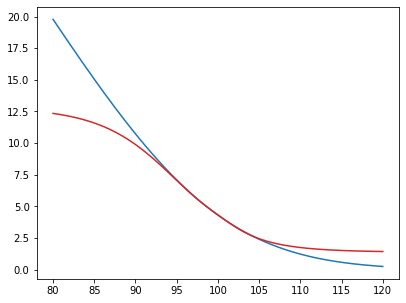

In [44]:
P_T_true = lambda x: K*np.exp(-r*(T-tau)) * stats.norm.cdf(-(np.log(x/K)+(r-0.5*sigma**2)*(T-tau))/(sigma*np.sqrt(T-tau))) - x*stats.norm.cdf(-(np.log(x/K)+(r+0.5*sigma**2)*(T-tau))/(sigma*np.sqrt(T-tau)))

u=np.linspace(80,120,250)
plt.figure(figsize=(6.5,5))
plt.plot(u,P_T_true(u), color='tab:blue')
plt.plot(u,model_IS.predict(u)[:,0], color='tab:red')
plt.show()

In [45]:
#The density function of Z
def f(y):
    return stats.norm.pdf(y, loc=0, scale=1)

#The density function of Z_\theta (note that \theta is replaced by x; this is needed for the least-squares solver to work)
def f_theta(x, y):
    return stats.norm.pdf(y, loc=x[0], scale=x[1])

def g_q_alpha_hat_reweighted(x,L,q_alpha_hat):
    return np.sqrt(f(y=L[:,0])/f_theta(y=L[:,0],x=x))*(L[:,-1]>q_alpha_hat)

bnds_lower = np.array([-np.inf,0])
bnds_upper = np.array([np.inf,np.inf])

L_MC_IS = np.column_stack((Z_IS, model_IS.predict(S_tau_IS)[:,0]))
L_IS = L_MC_IS[L_MC_IS[:,-1].argsort()[::-1]]
q_alpha_hat_IS = L_IS[int(M_IS*(1-alpha_IS)-1), -1]

IS = optimize.least_squares(g_q_alpha_hat_reweighted, x0=np.array([0,1]), bounds=(bnds_lower,bnds_upper), args=(L_MC_IS, q_alpha_hat_IS))

/scratch/slurm_tmpdir/job_20167821/ipykernel_2599471/3635139501.py:8: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(f(y=L[:,0])/f_theta(y=L[:,0],x=x))*(L[:,-1]>q_alpha_hat)
/scratch/slurm_tmpdir/job_20167821/ipykernel_2599471/3635139501.py:8: RuntimeWarning: overflow encountered in true_divide
  return np.sqrt(f(y=L[:,0])/f_theta(y=L[:,0],x=x))*(L[:,-1]>q_alpha_hat)
/scratch/slurm_tmpdir/job_20167821/ipykernel_2599471/3635139501.py:8: RuntimeWarning: invalid value encountered in multiply
  return np.sqrt(f(y=L[:,0])/f_theta(y=L[:,0],x=x))*(L[:,-1]>q_alpha_hat)


In [46]:
IS.x

array([-2.84958198,  0.40342672])

In [47]:
models_eval = []
for i in range(1,41):
    models_eval.append(tf.keras.models.load_model(filepath_wd + "Put_IS2_saved_epoch_learning_test_" + str(i) + ".hdf5"))

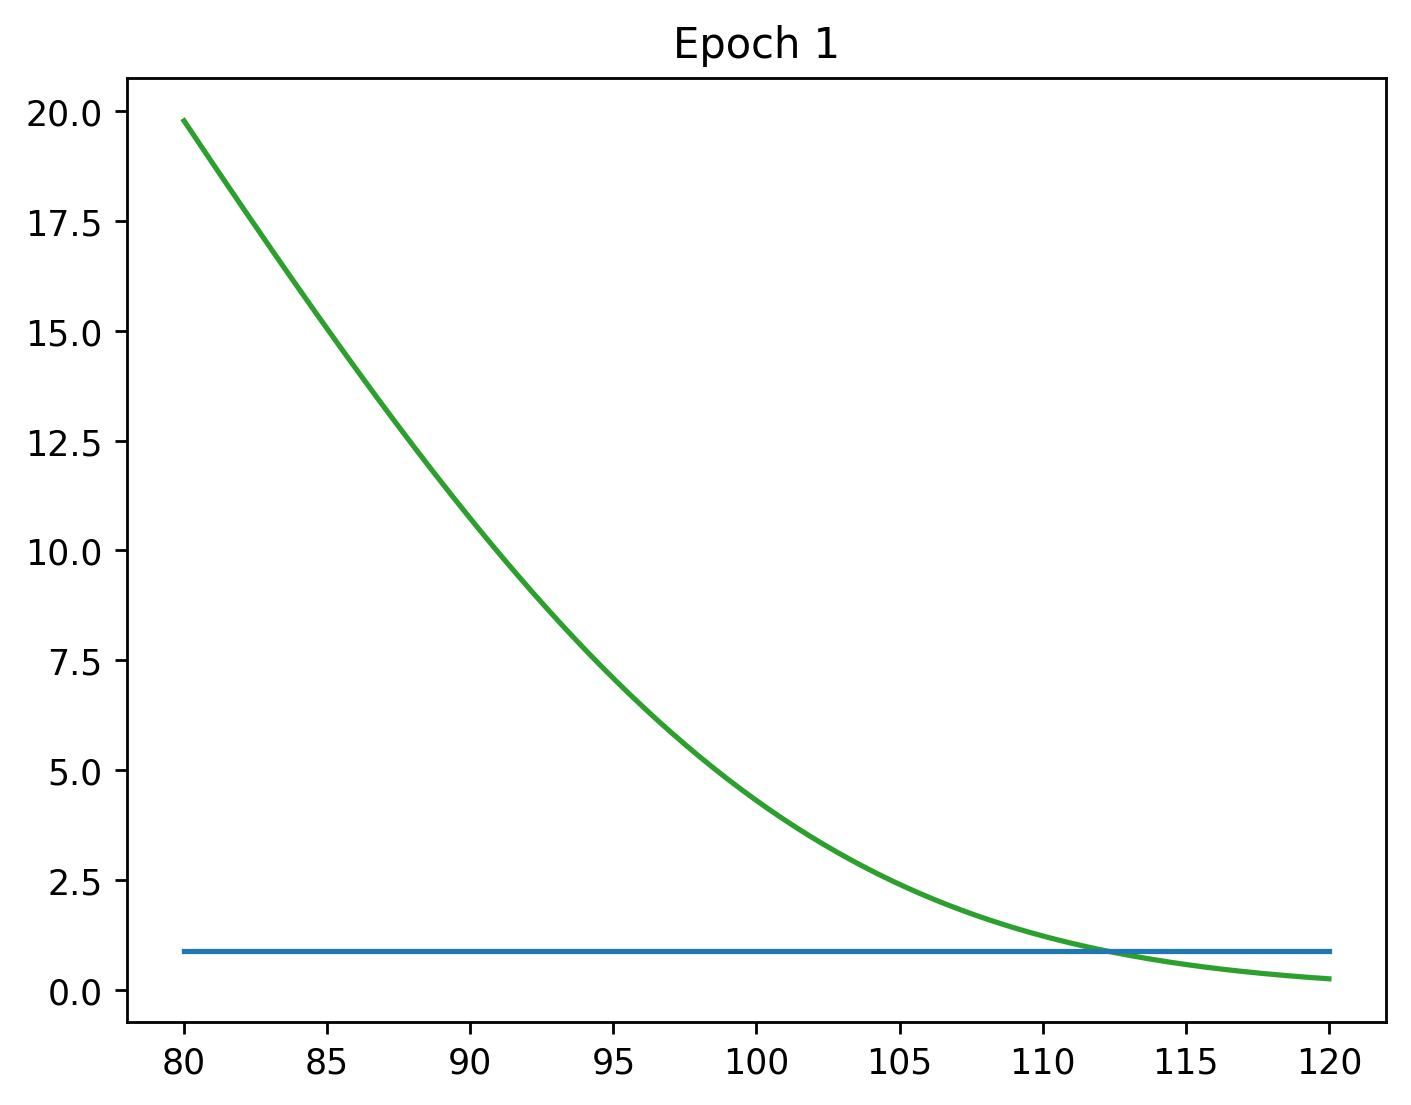

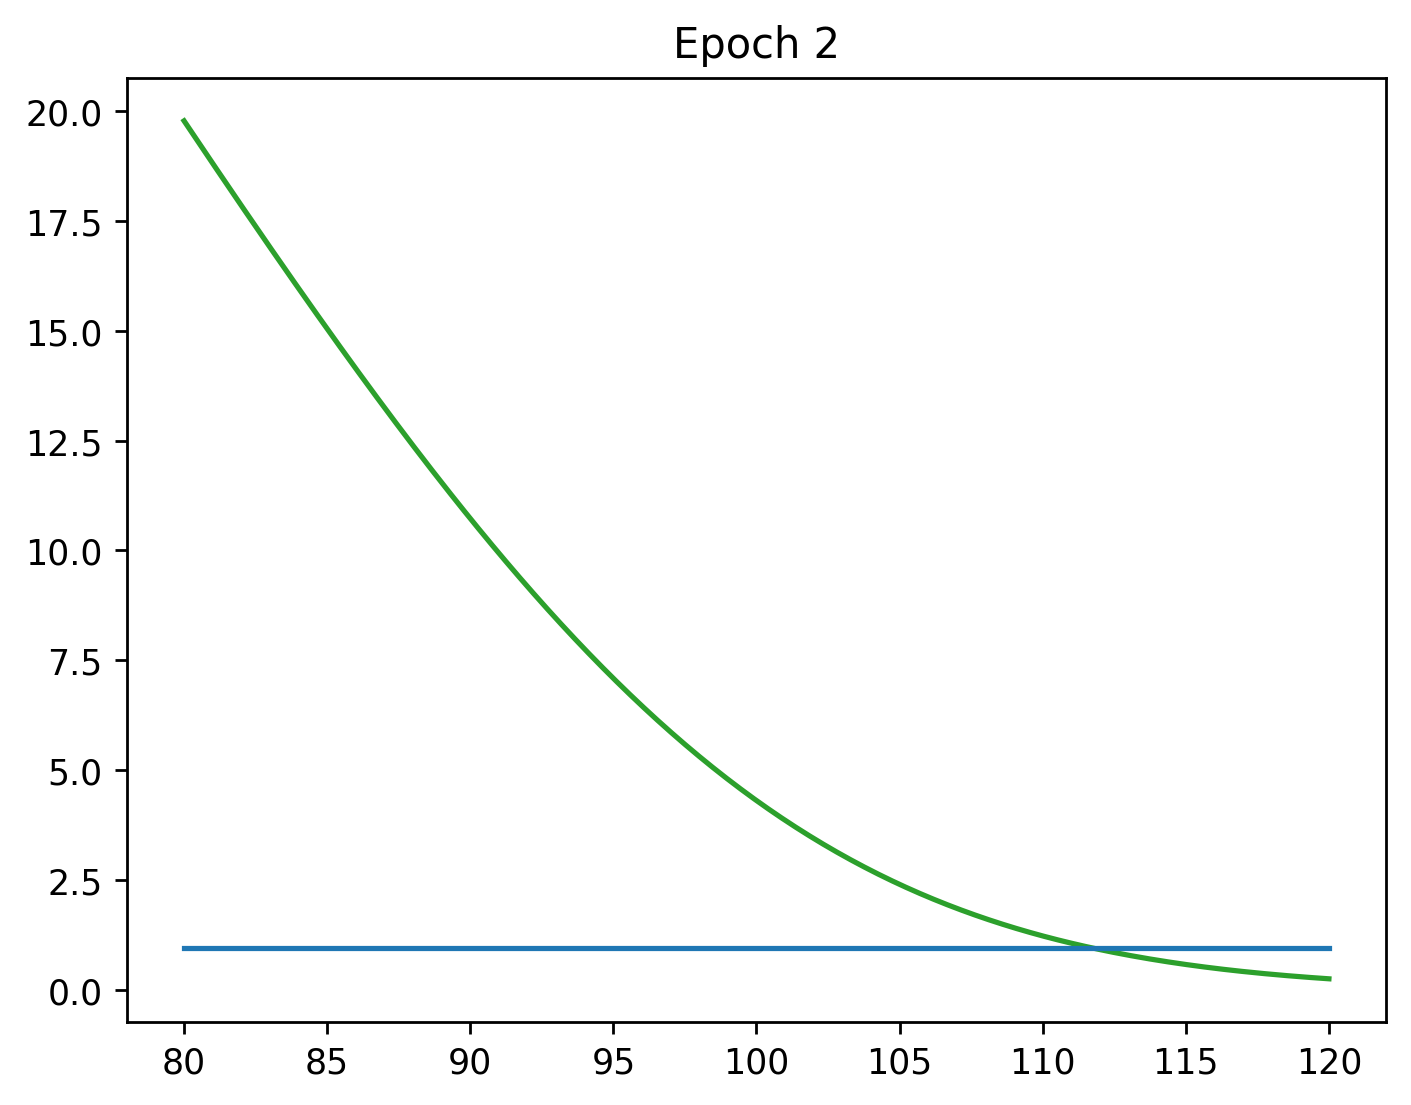

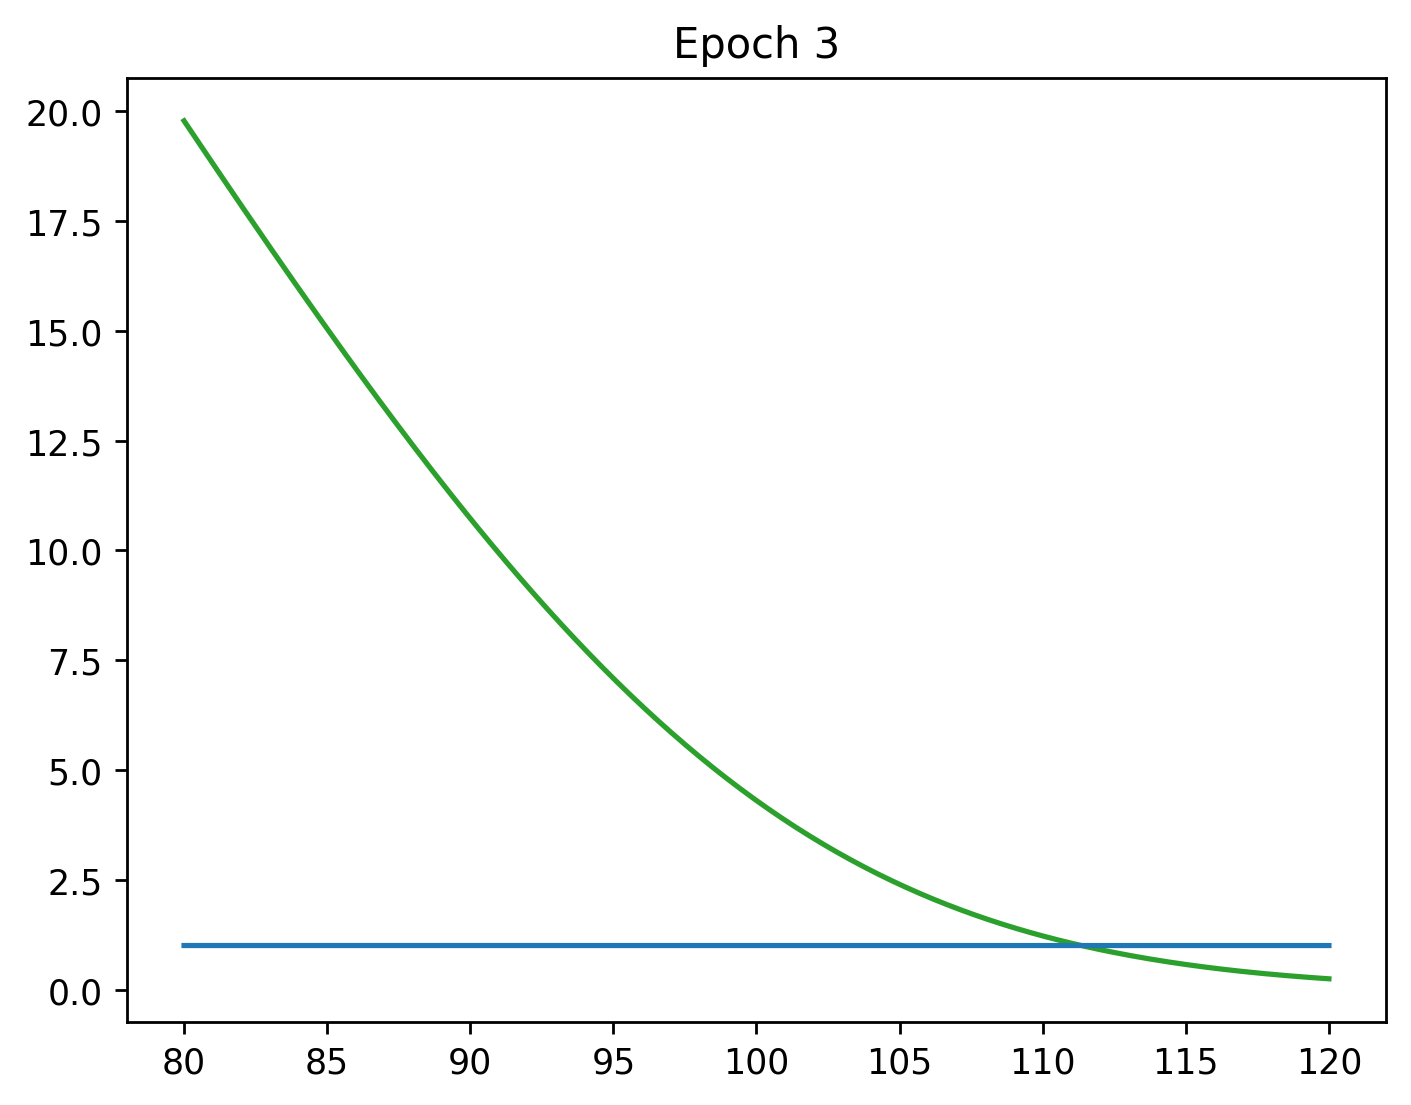

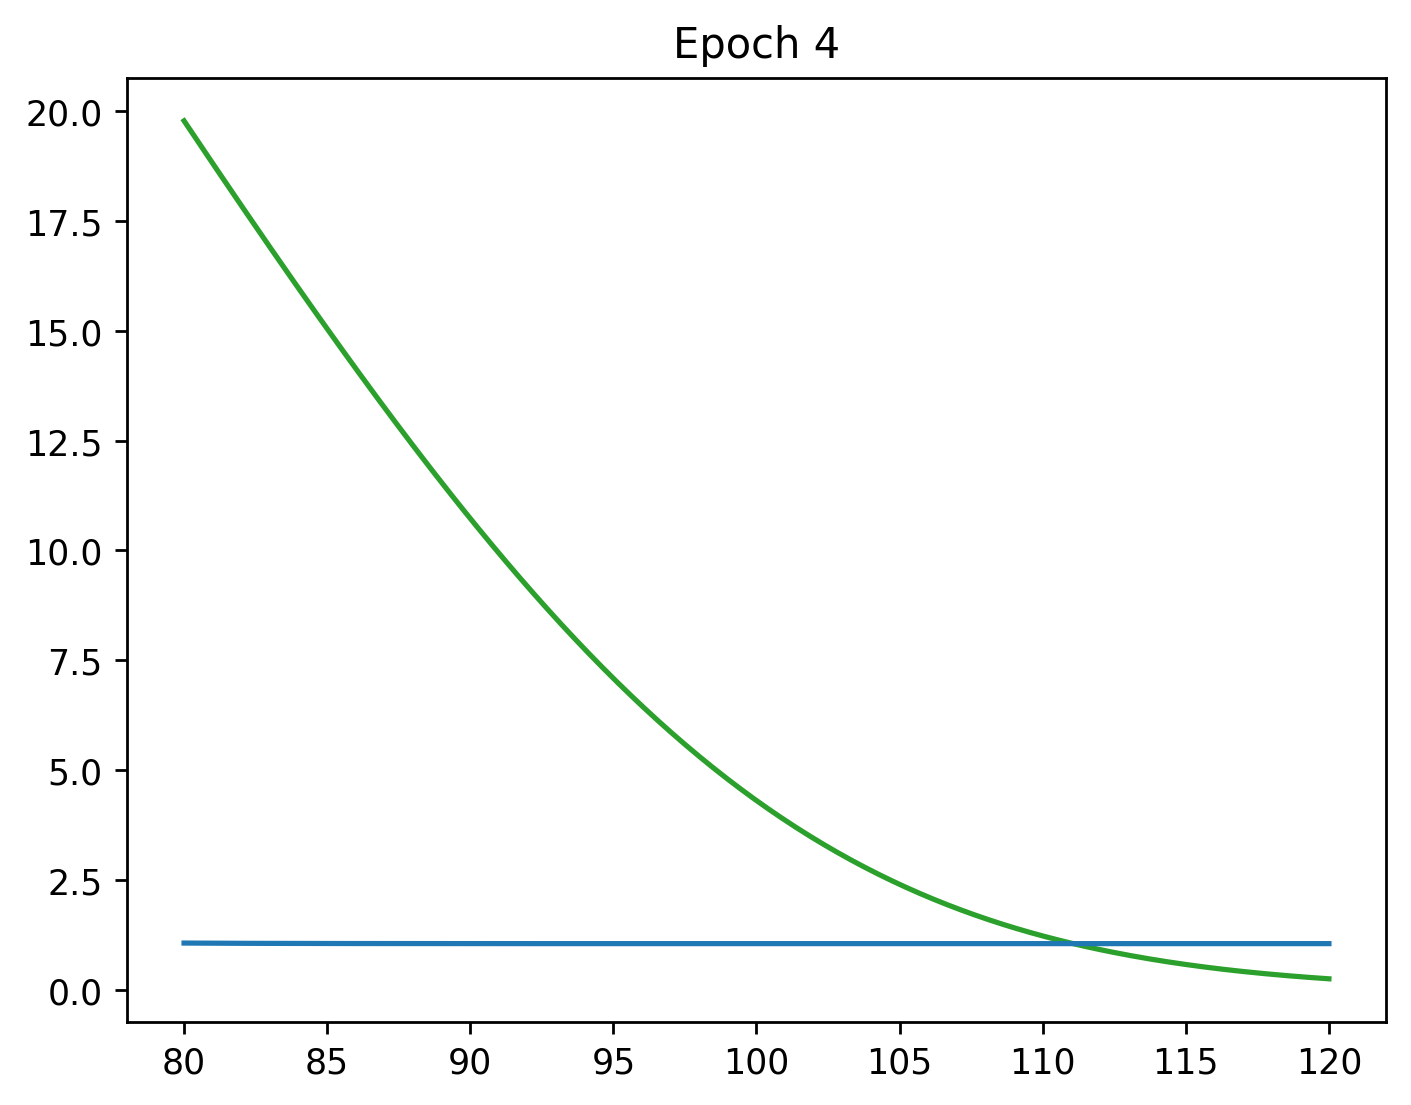

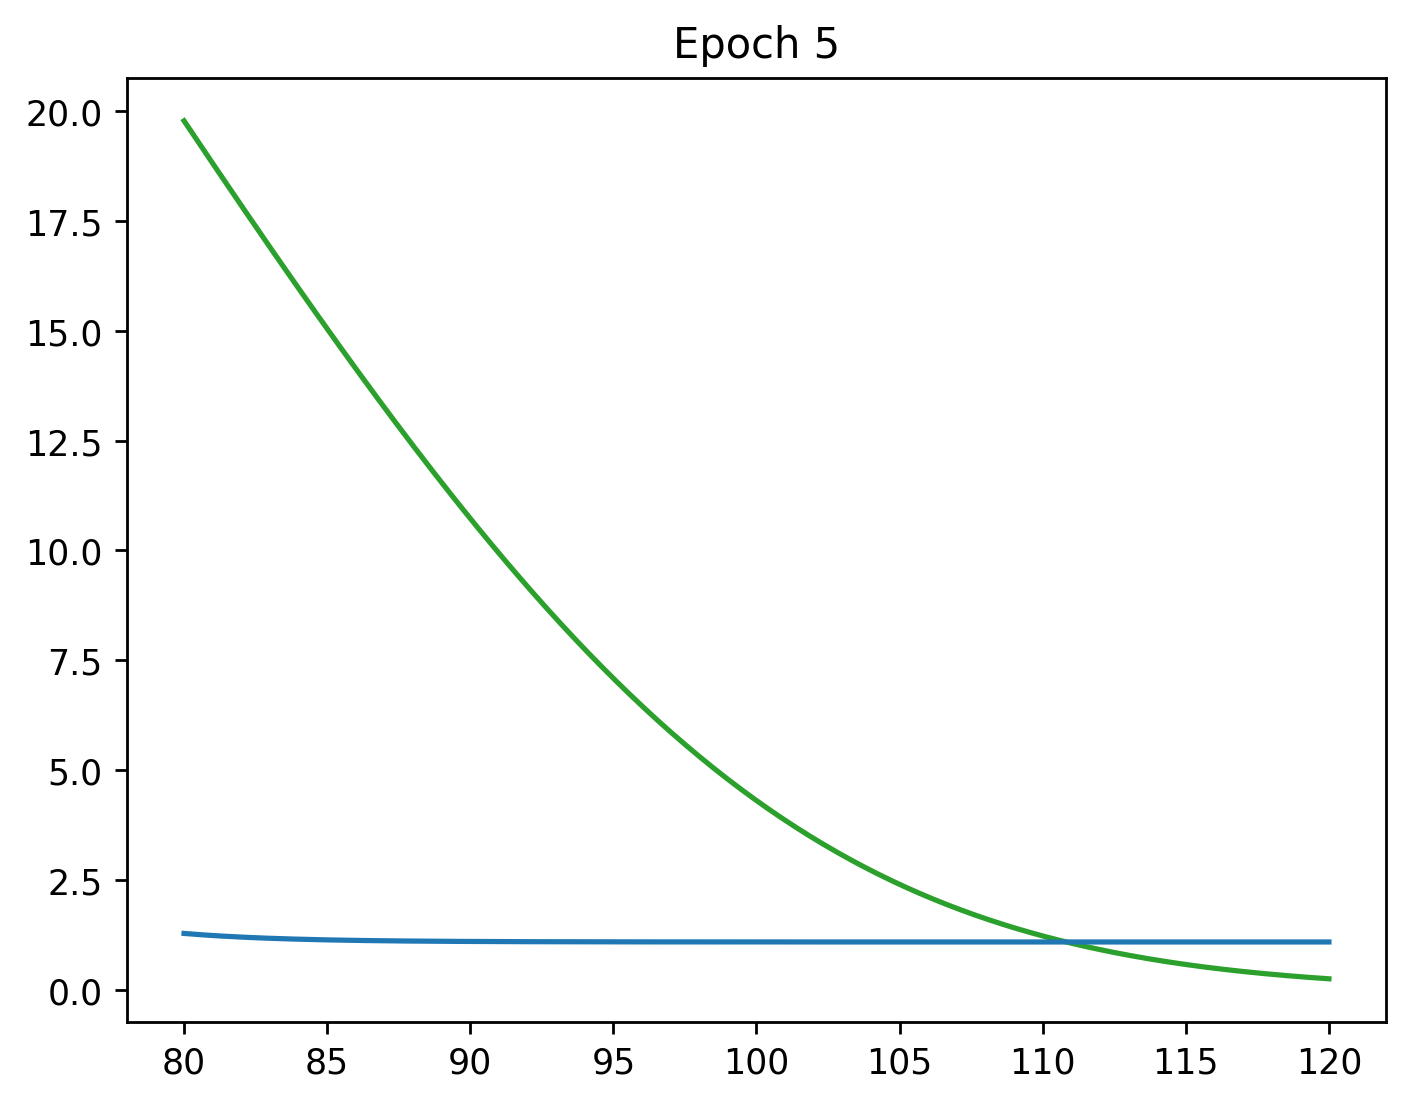

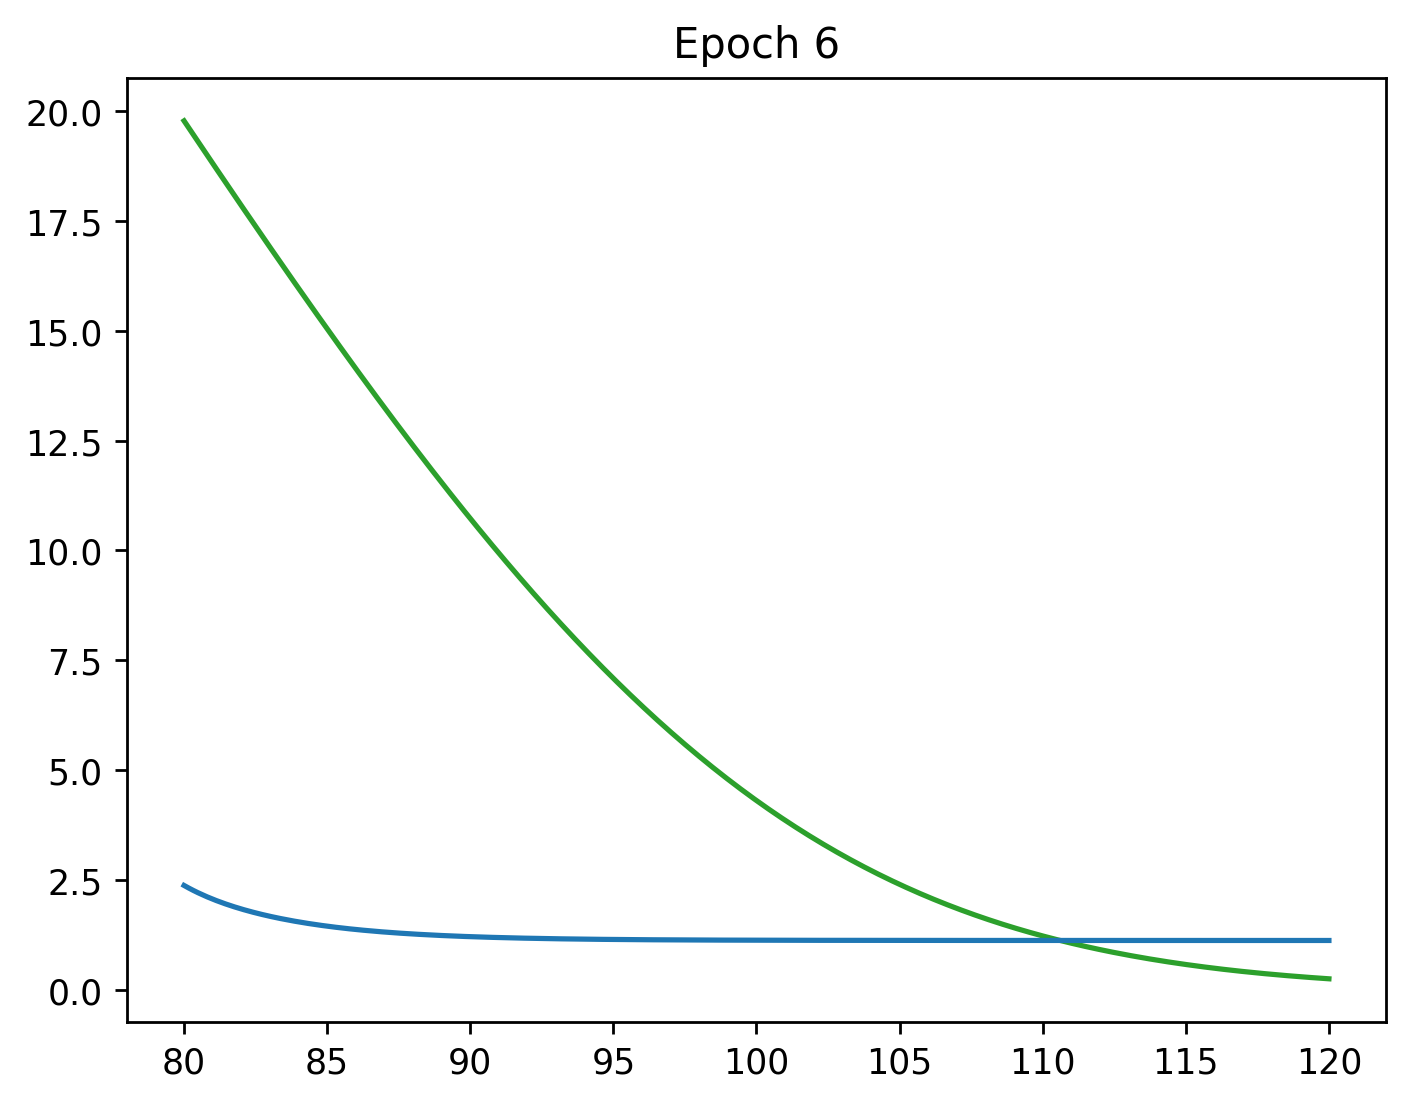

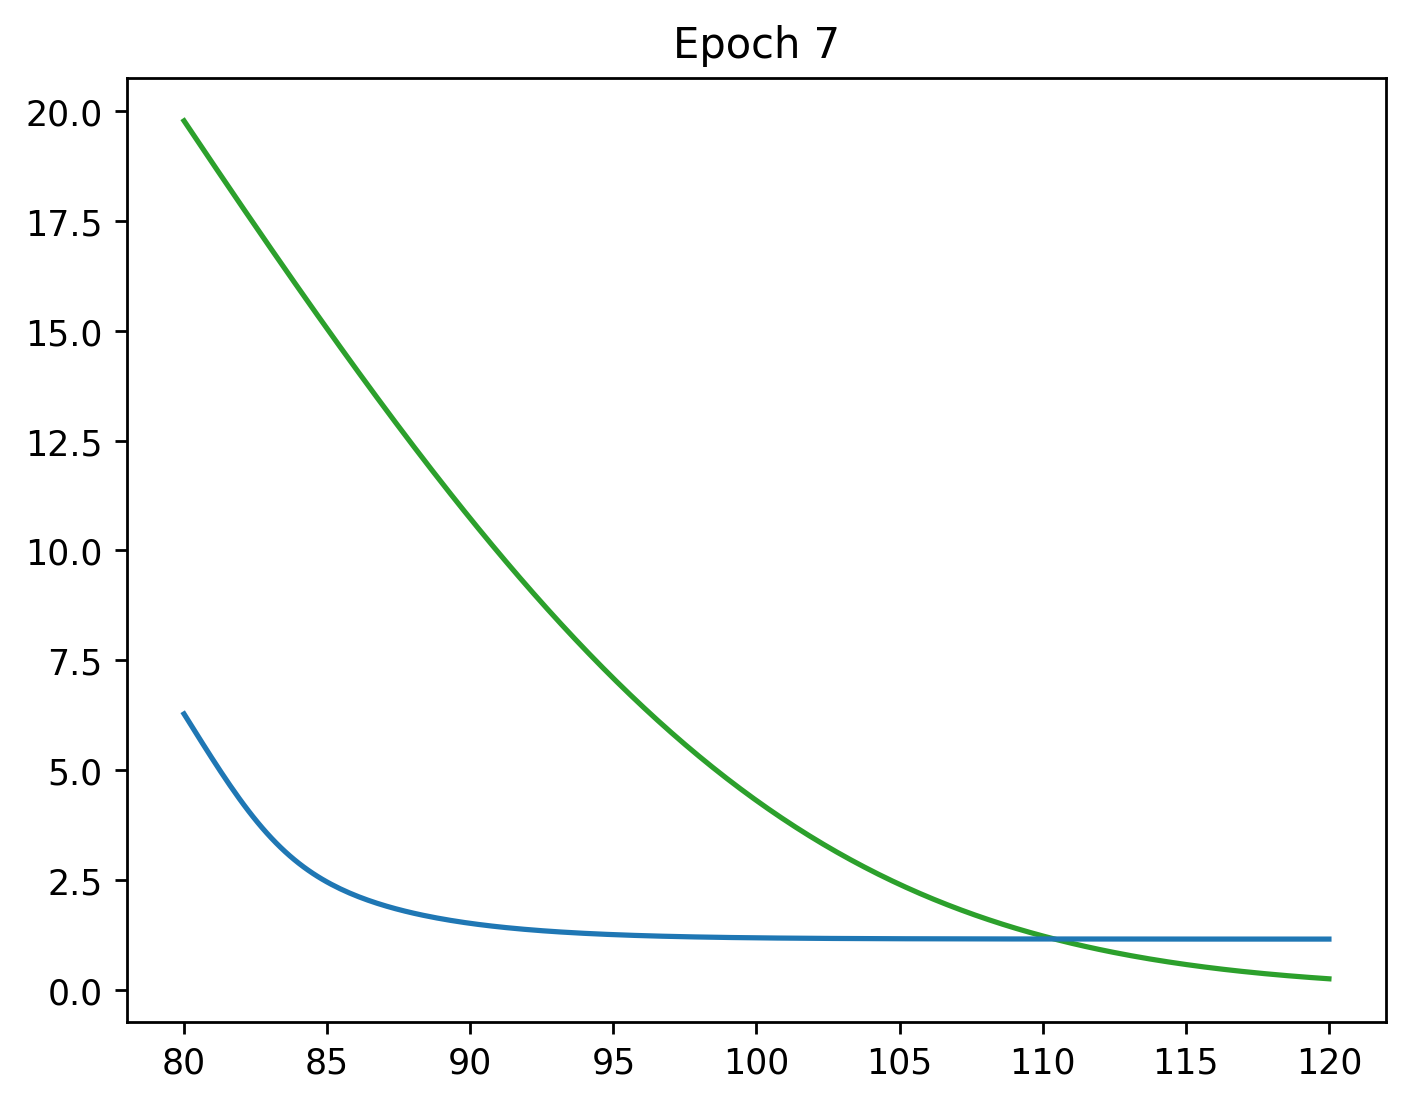

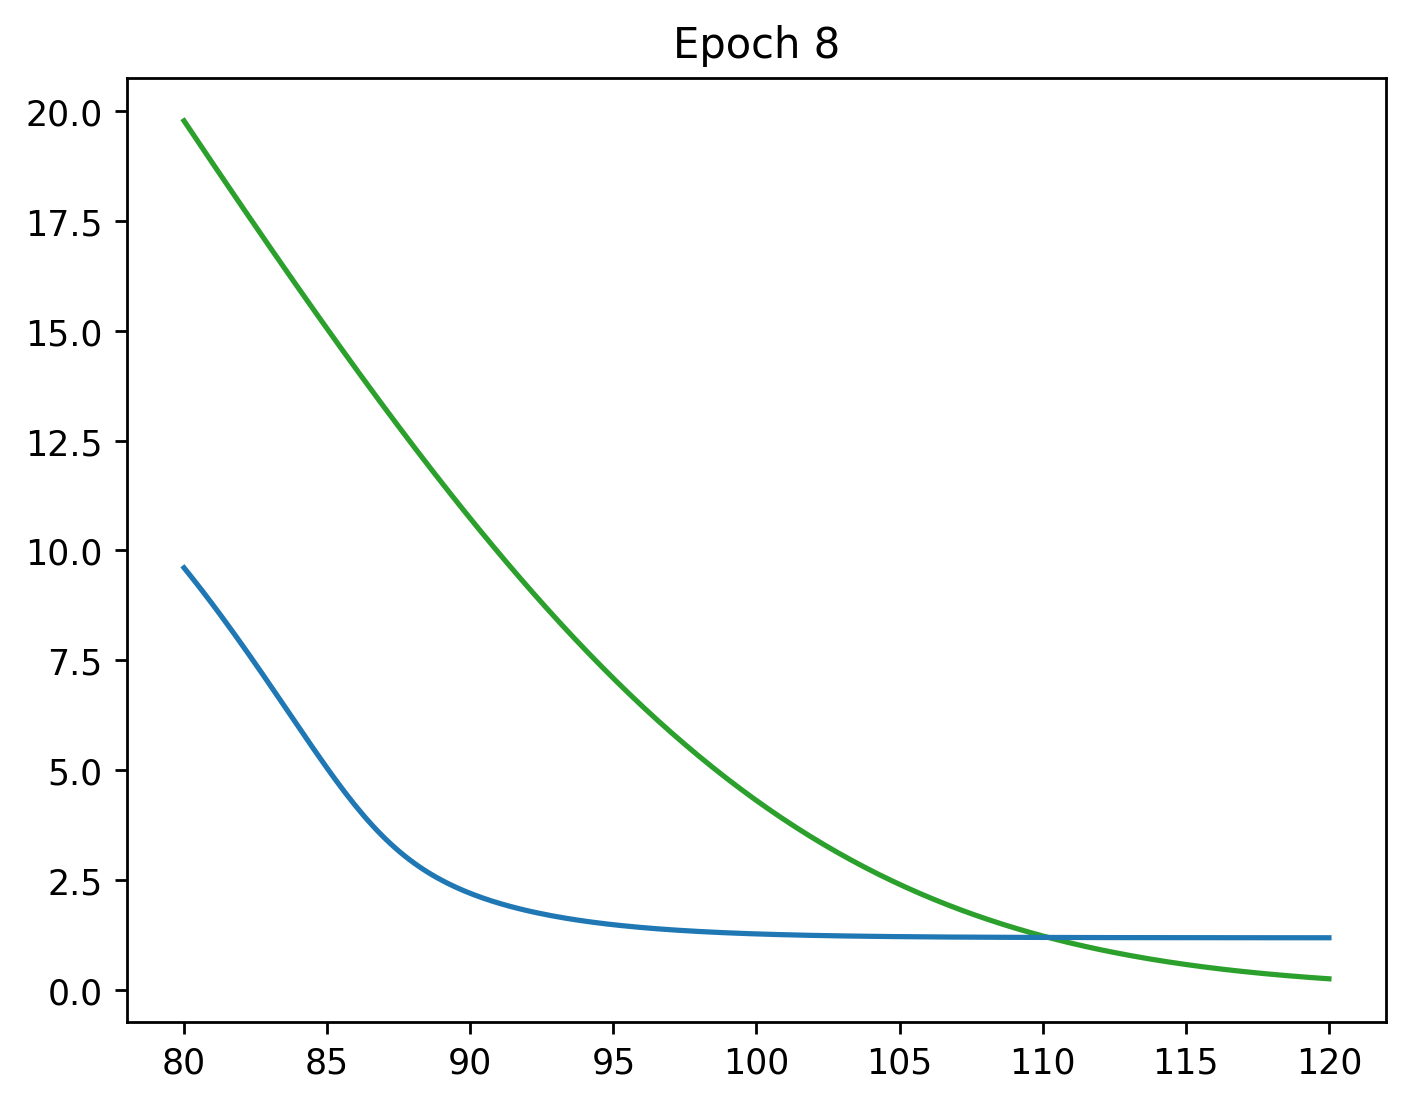

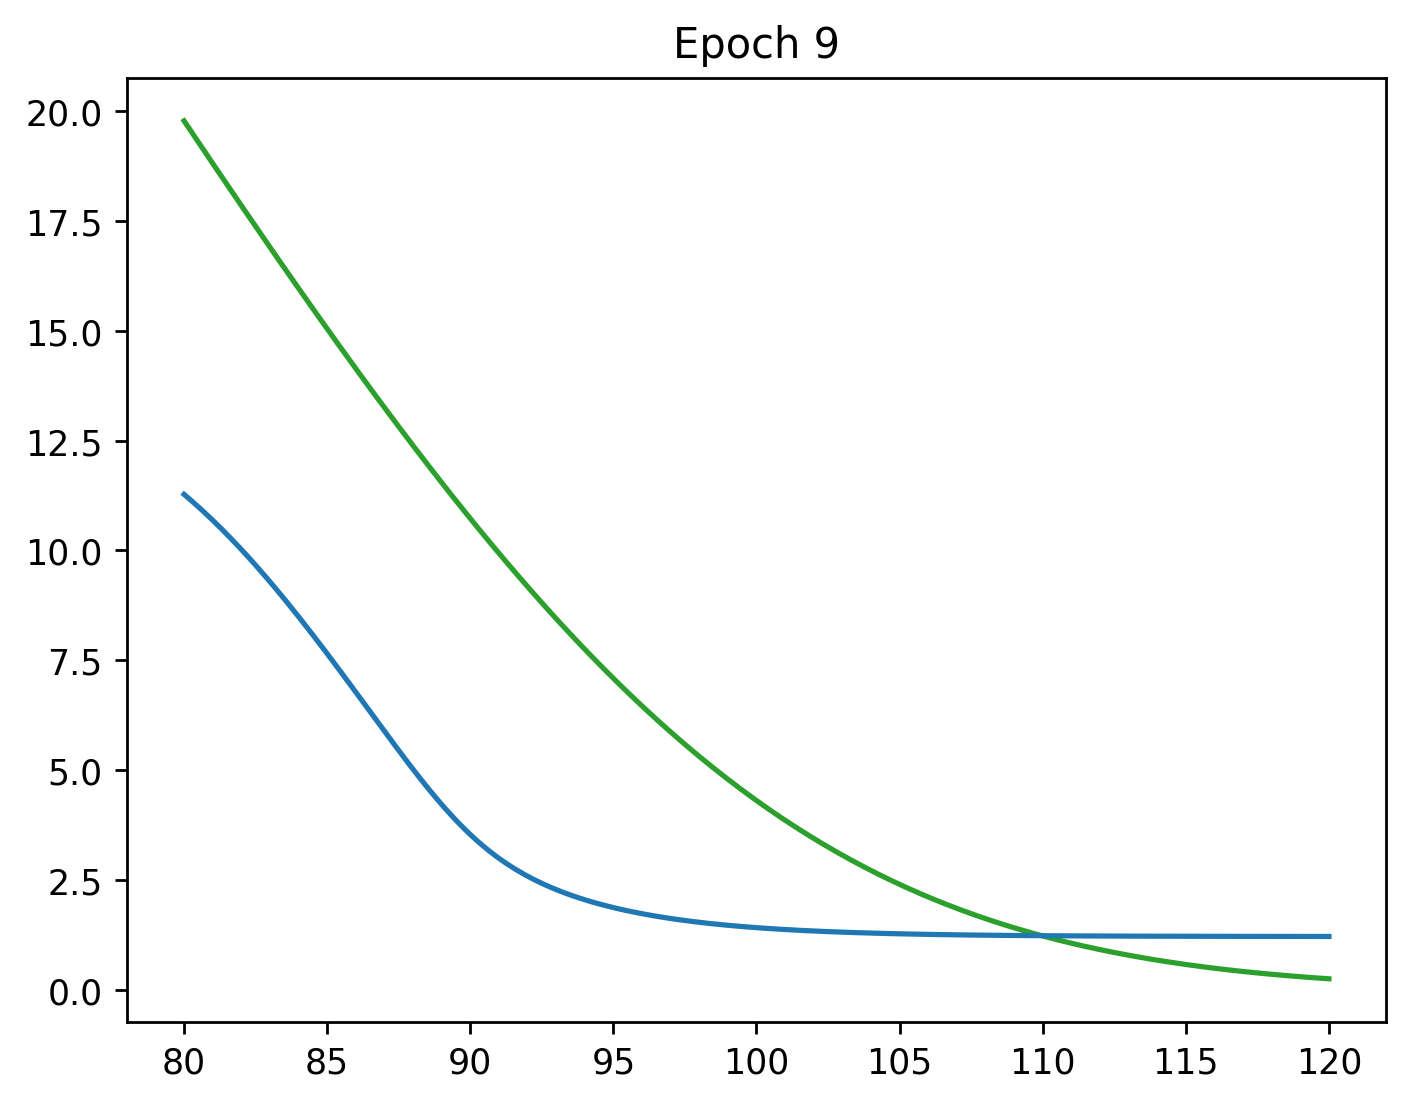

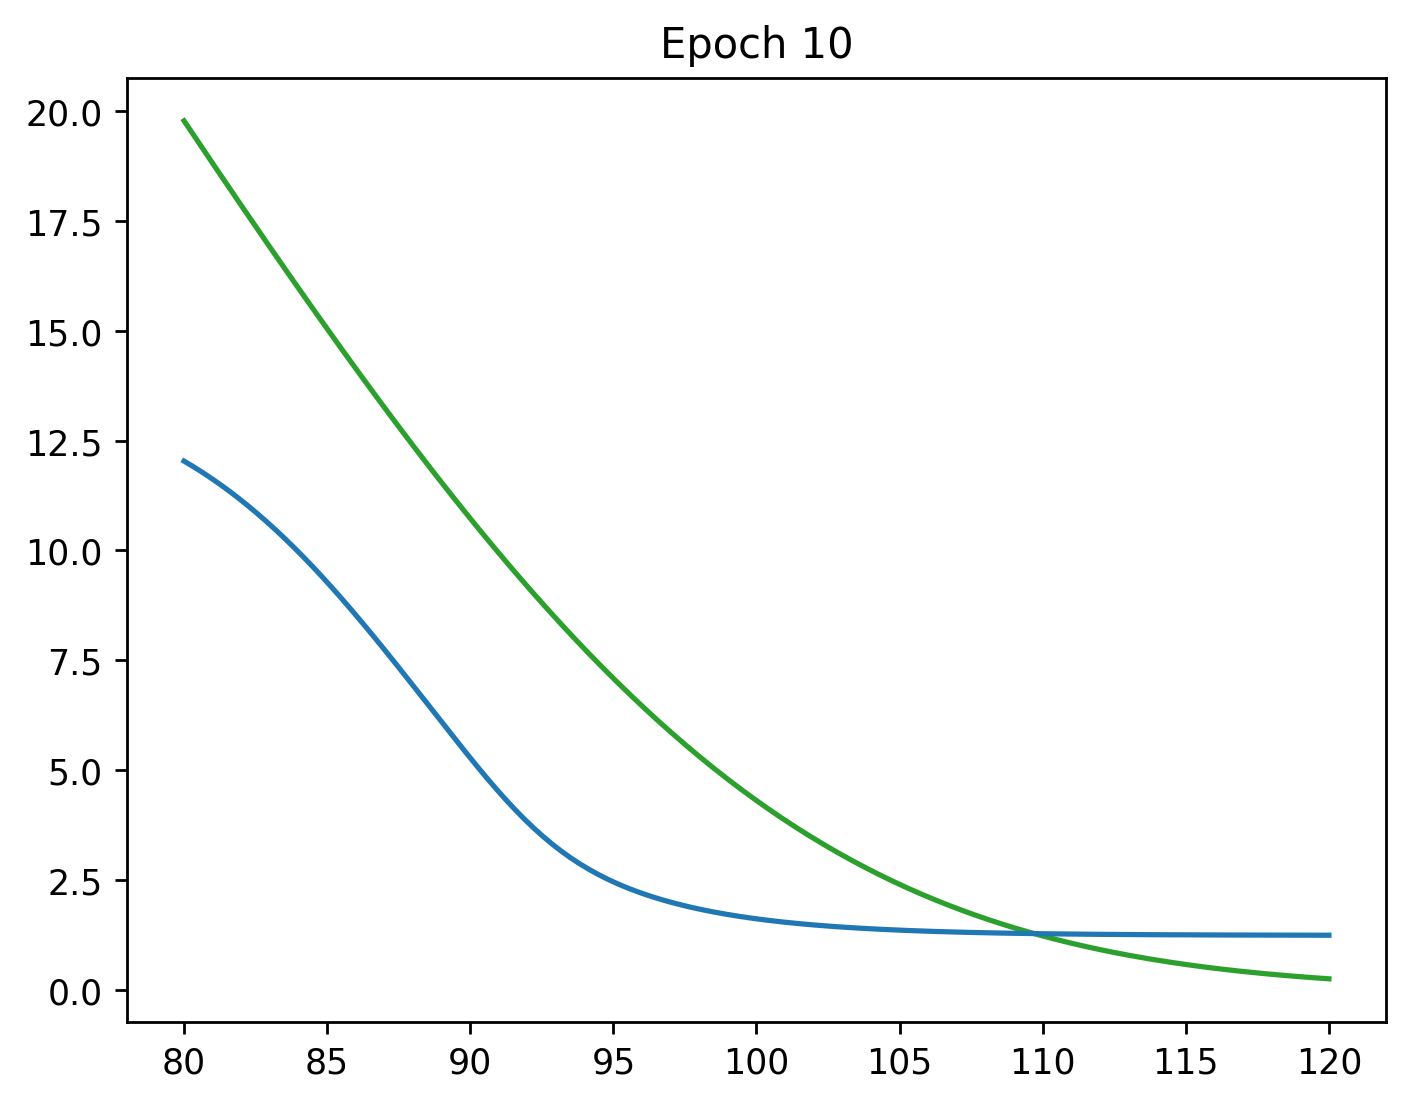

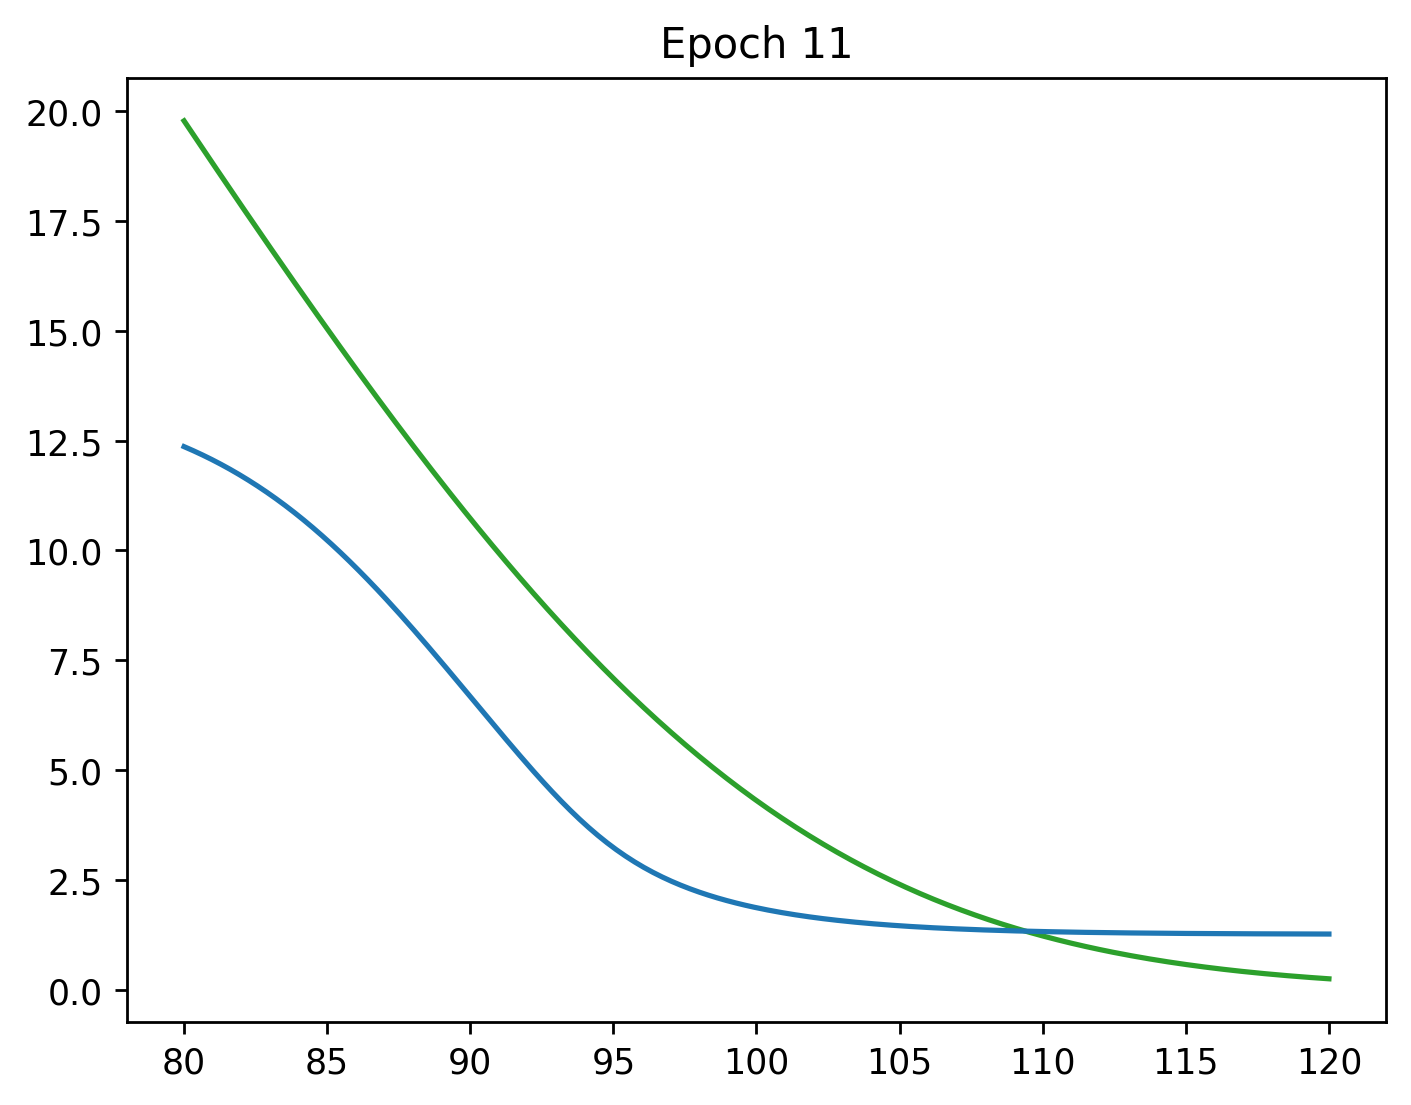

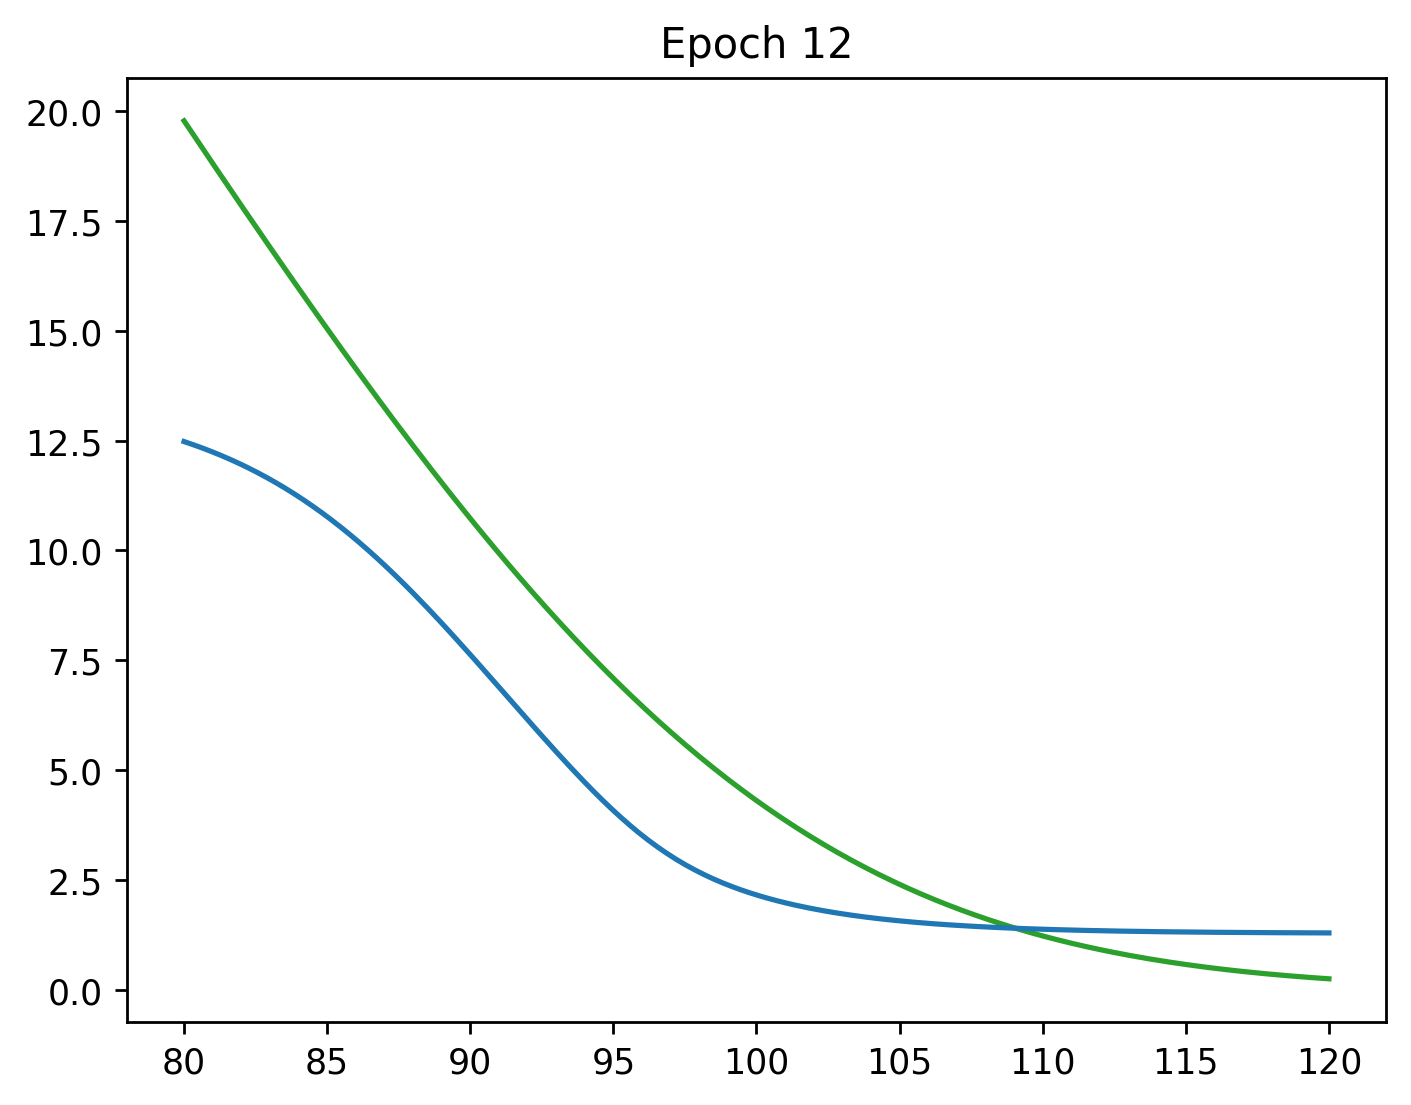

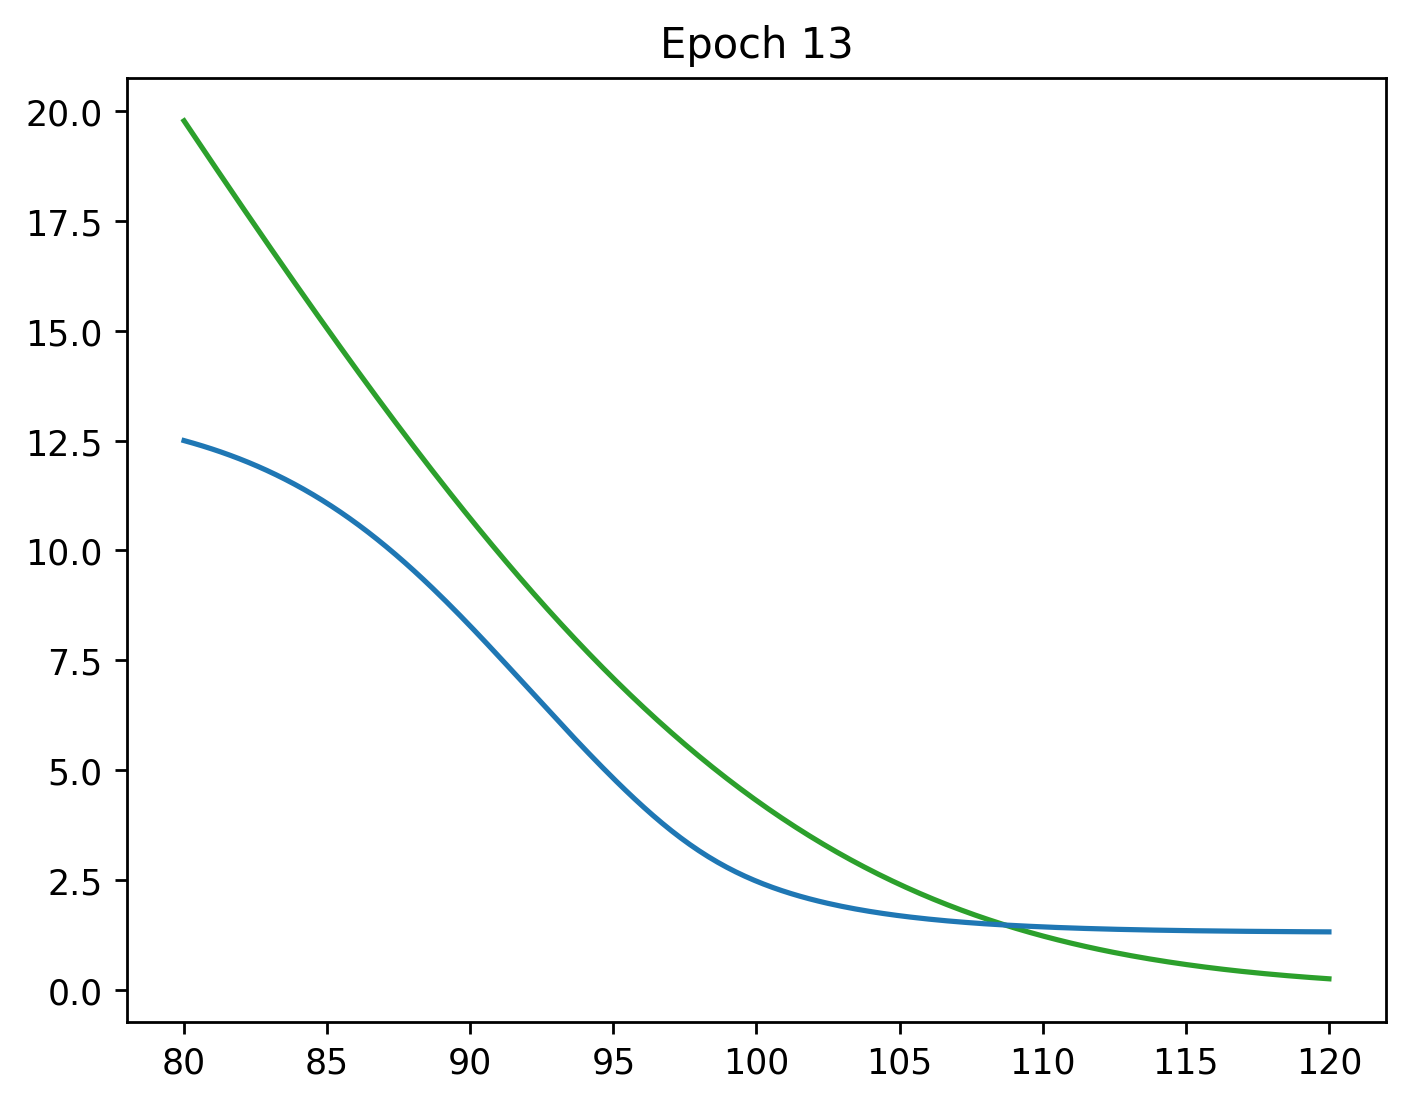

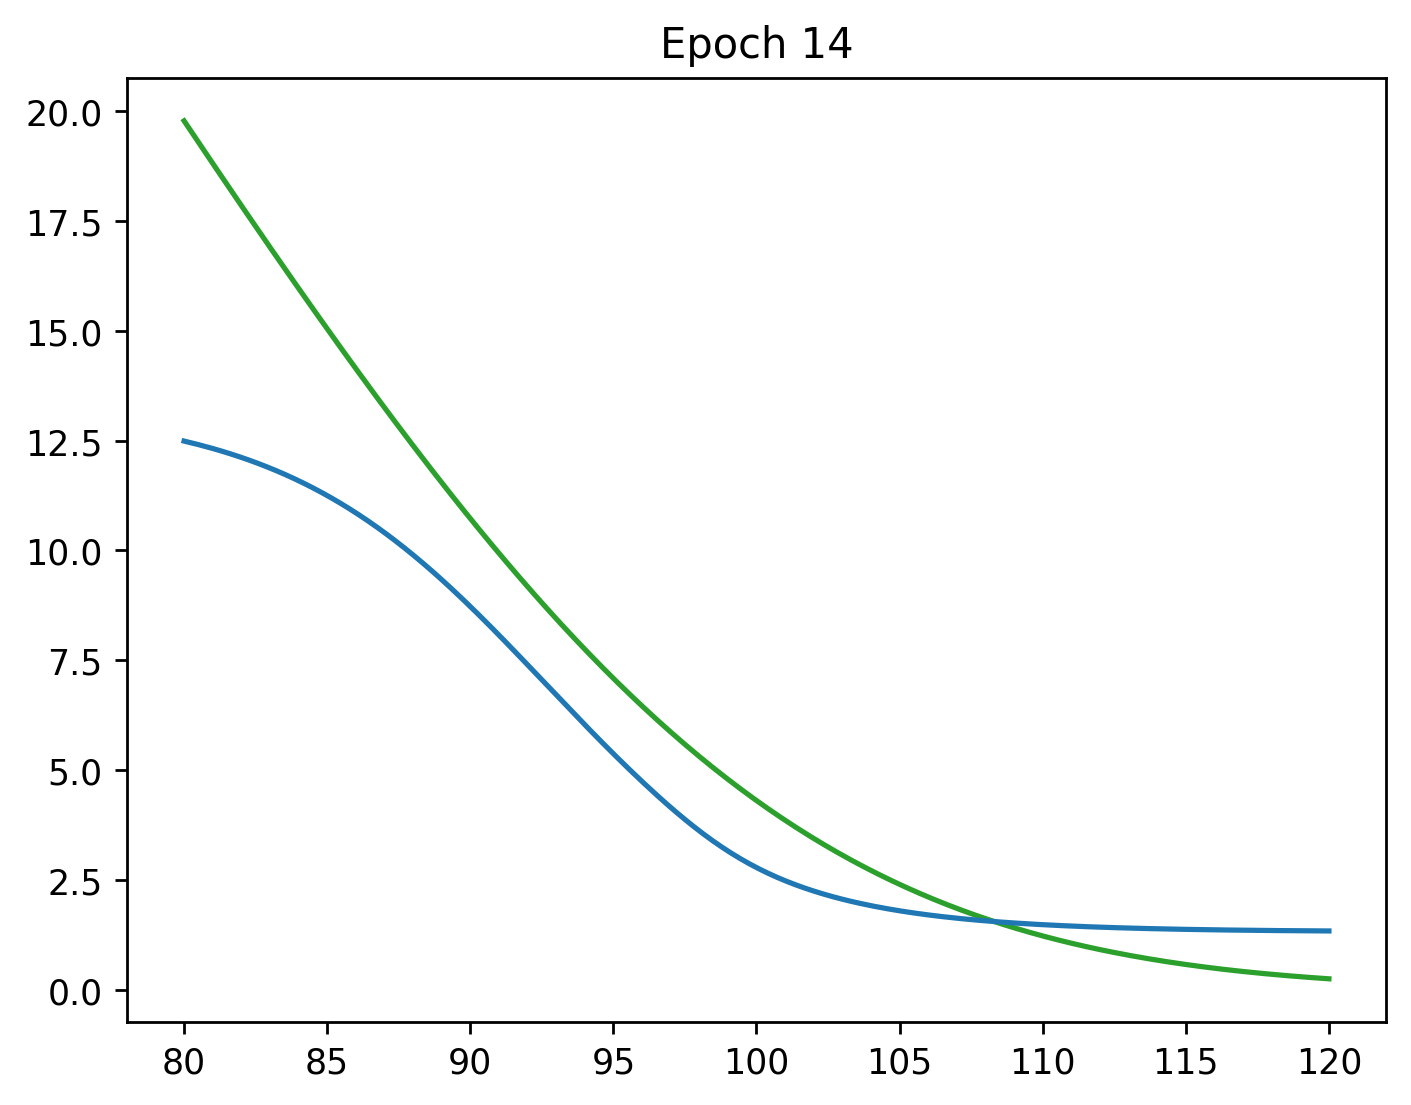

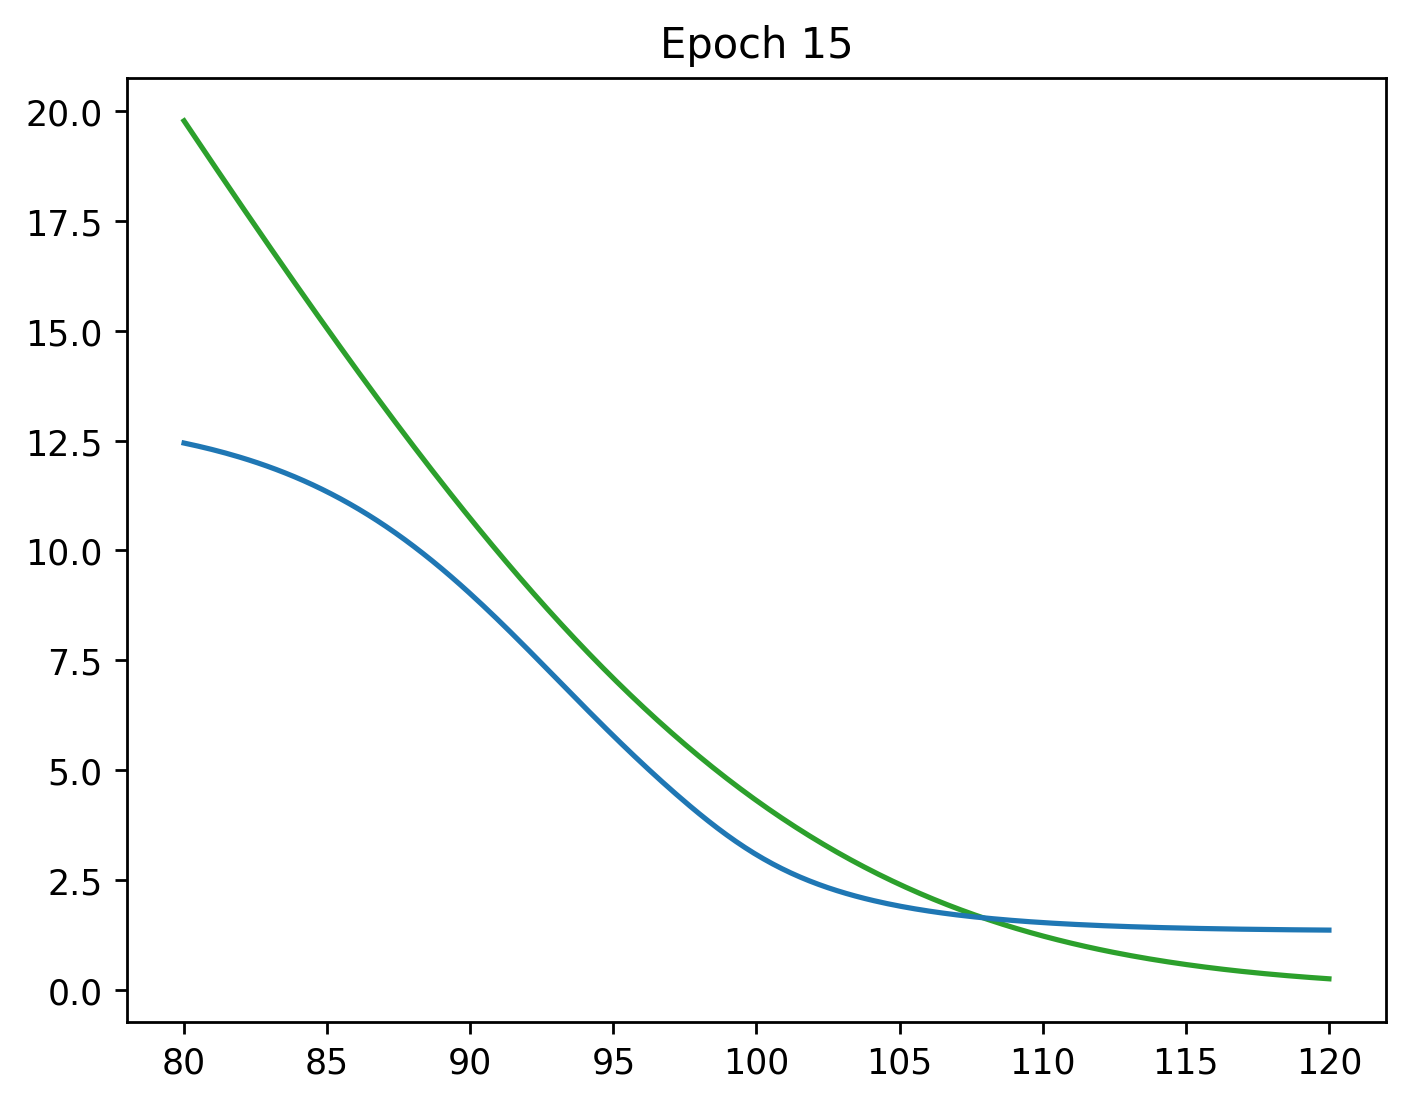

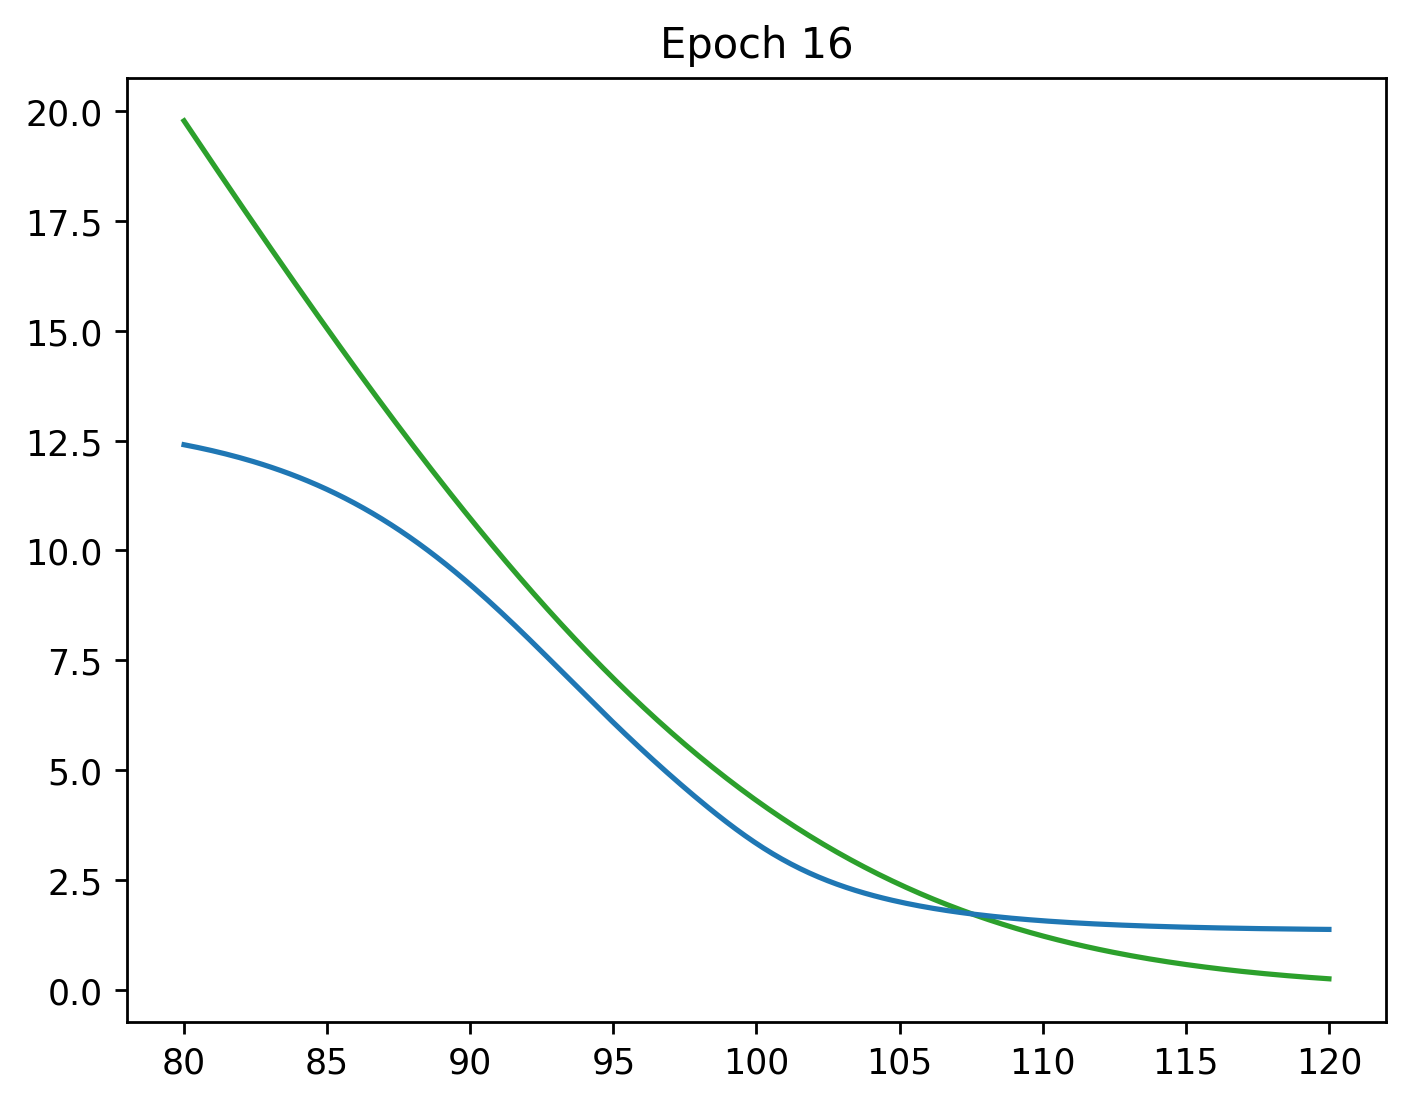

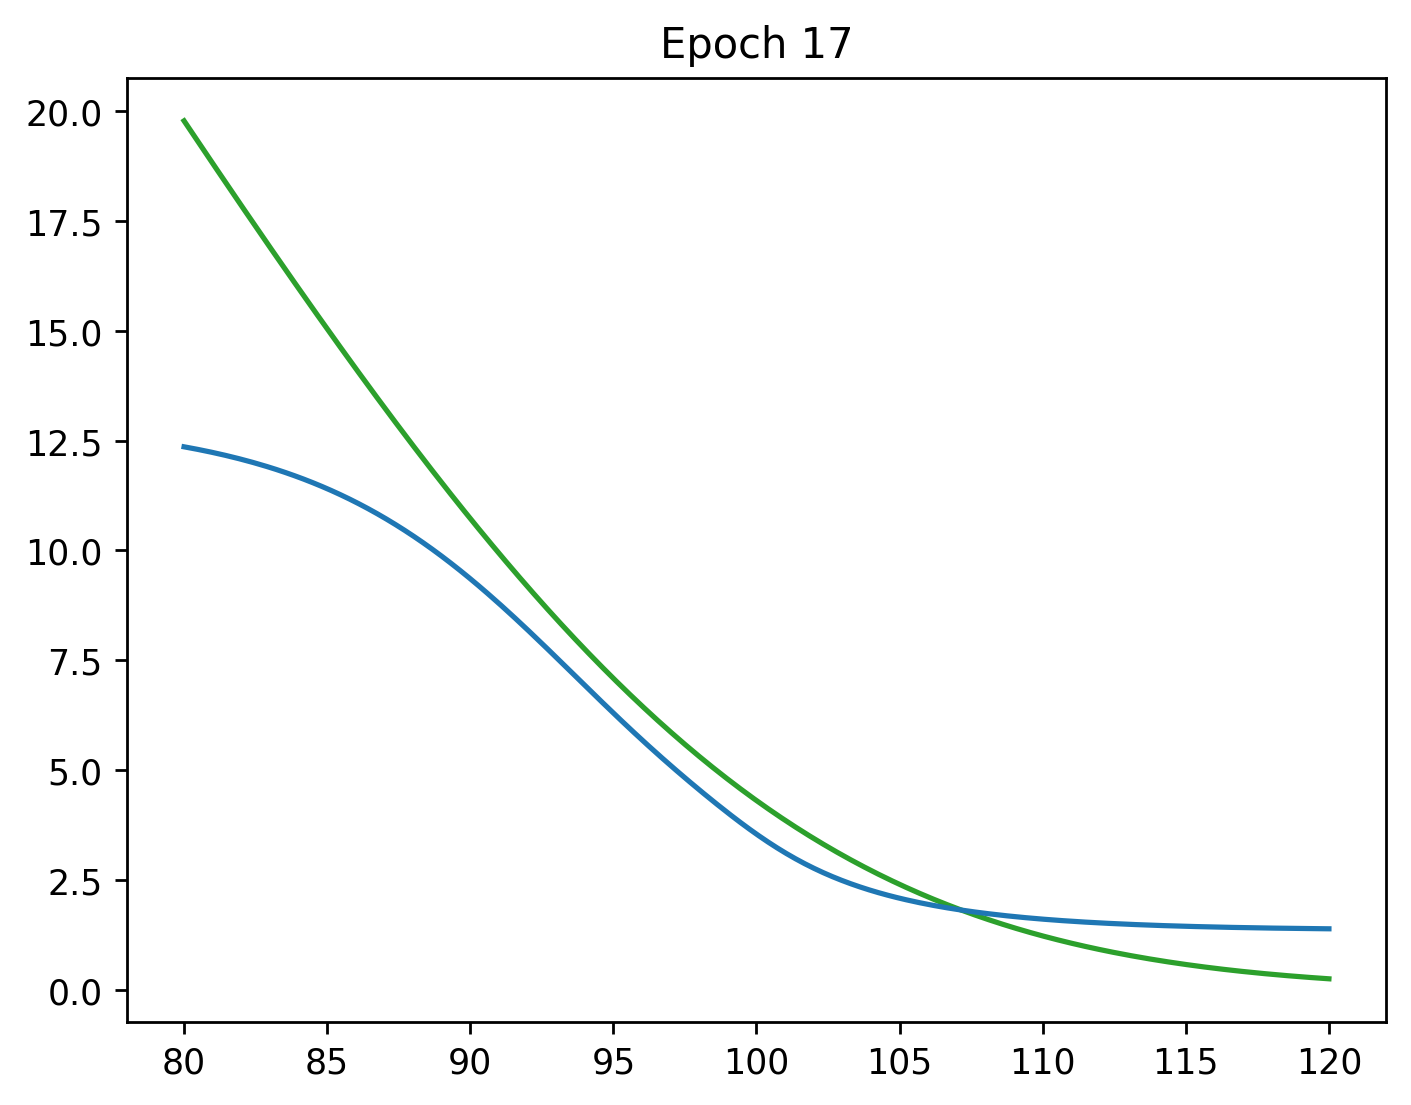

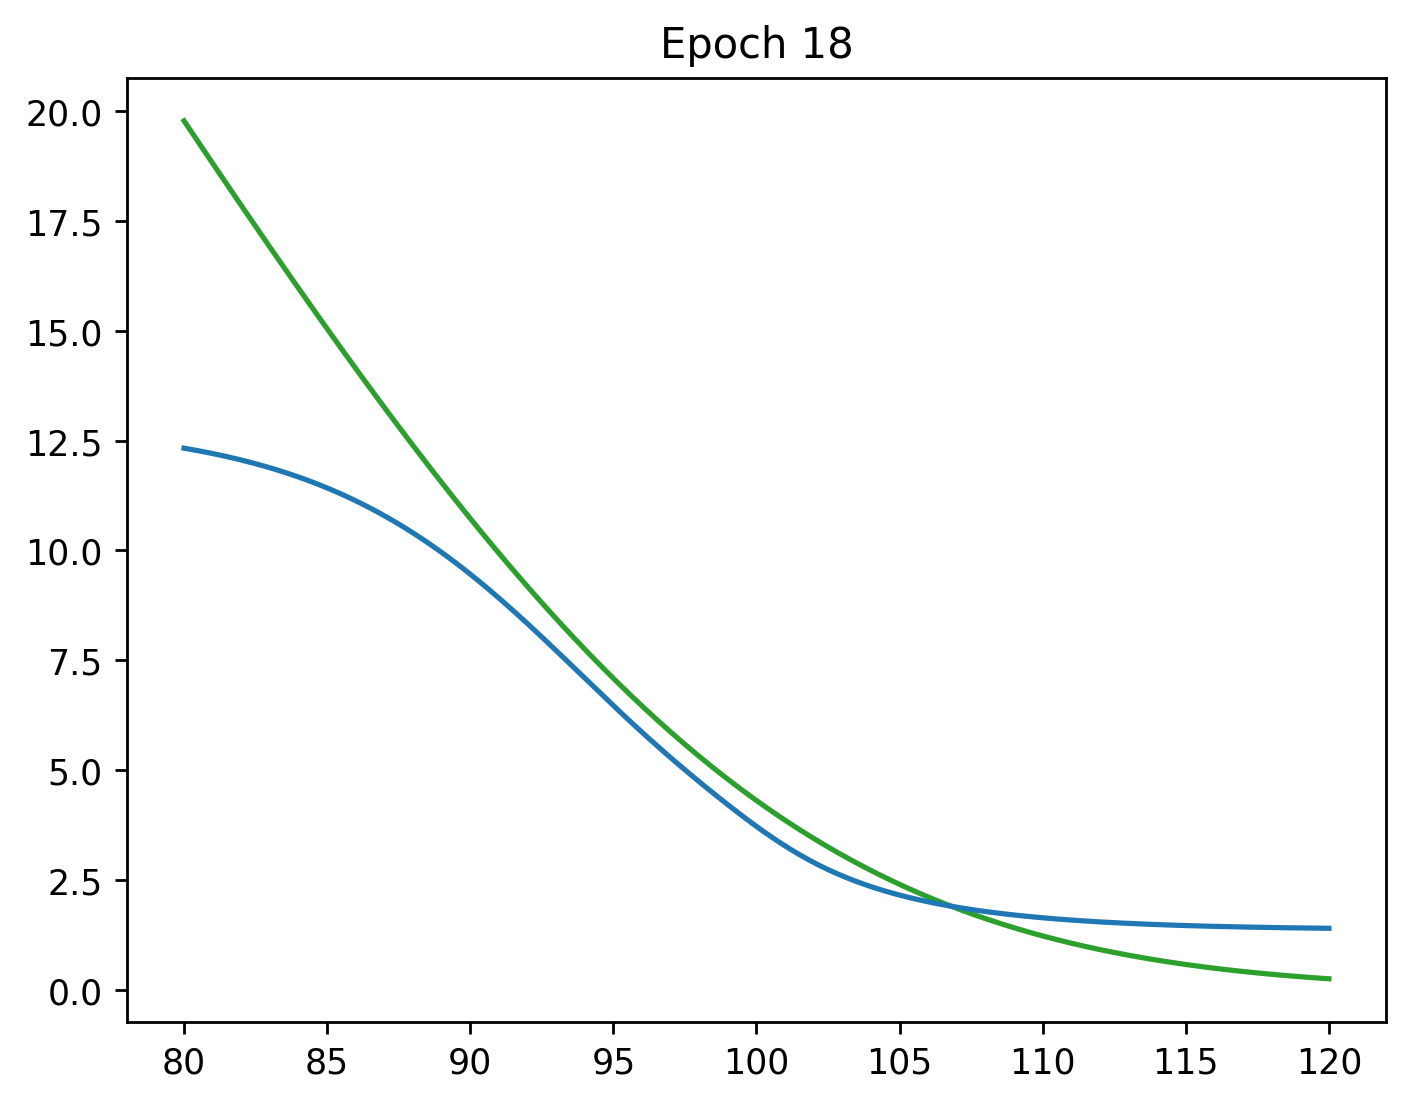

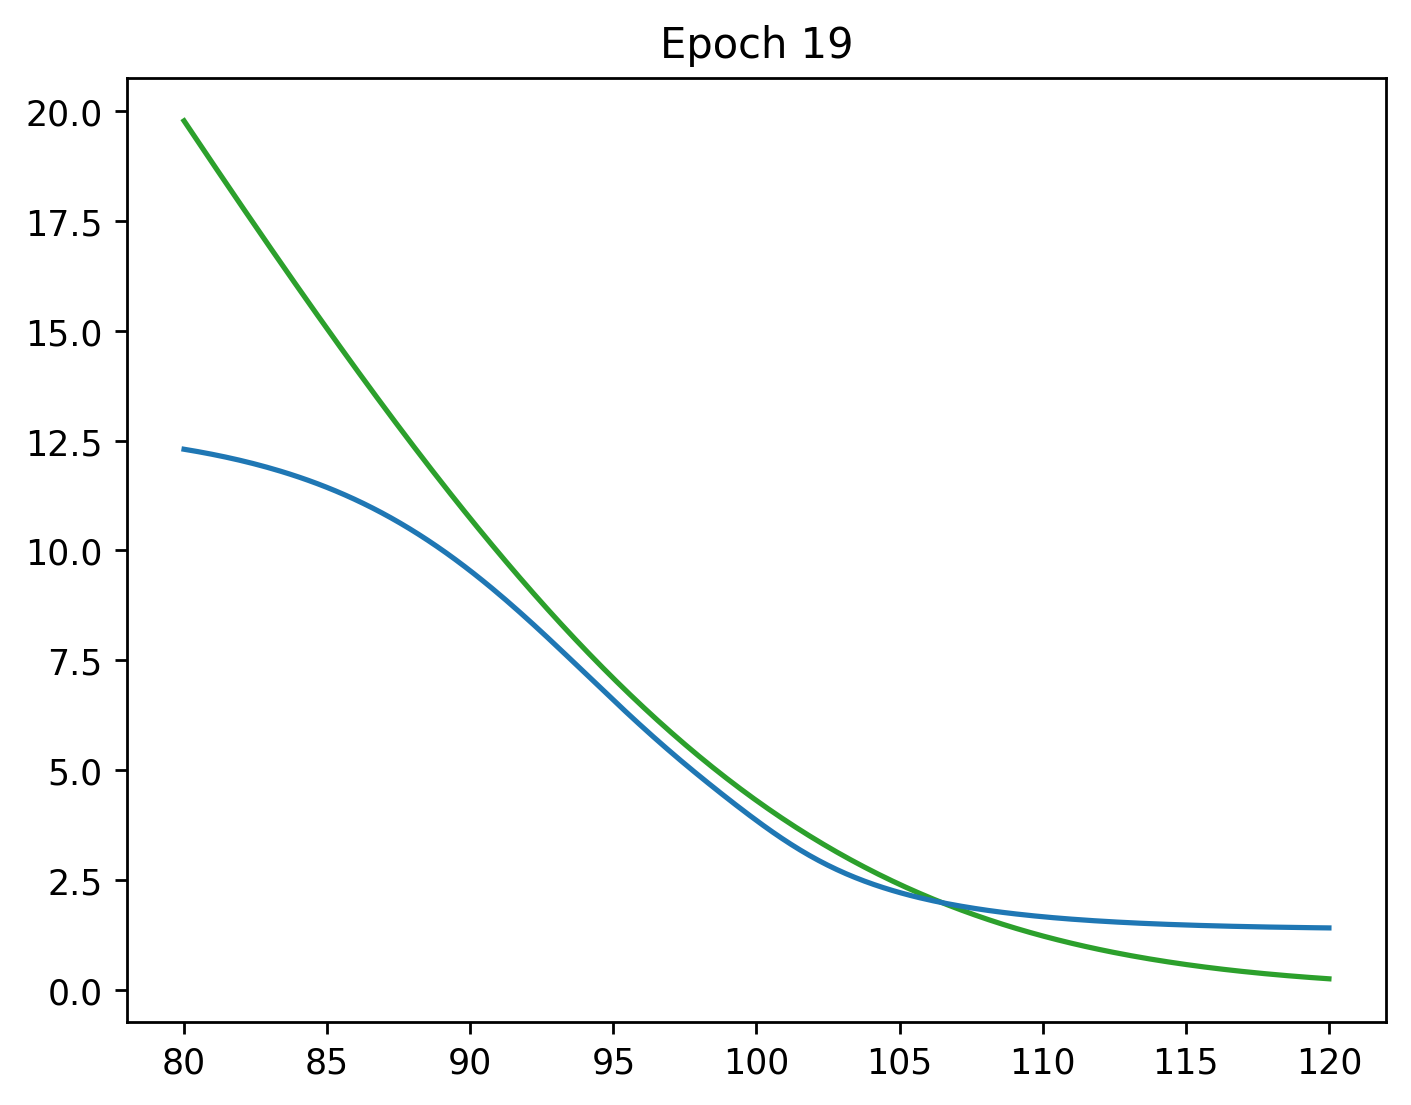

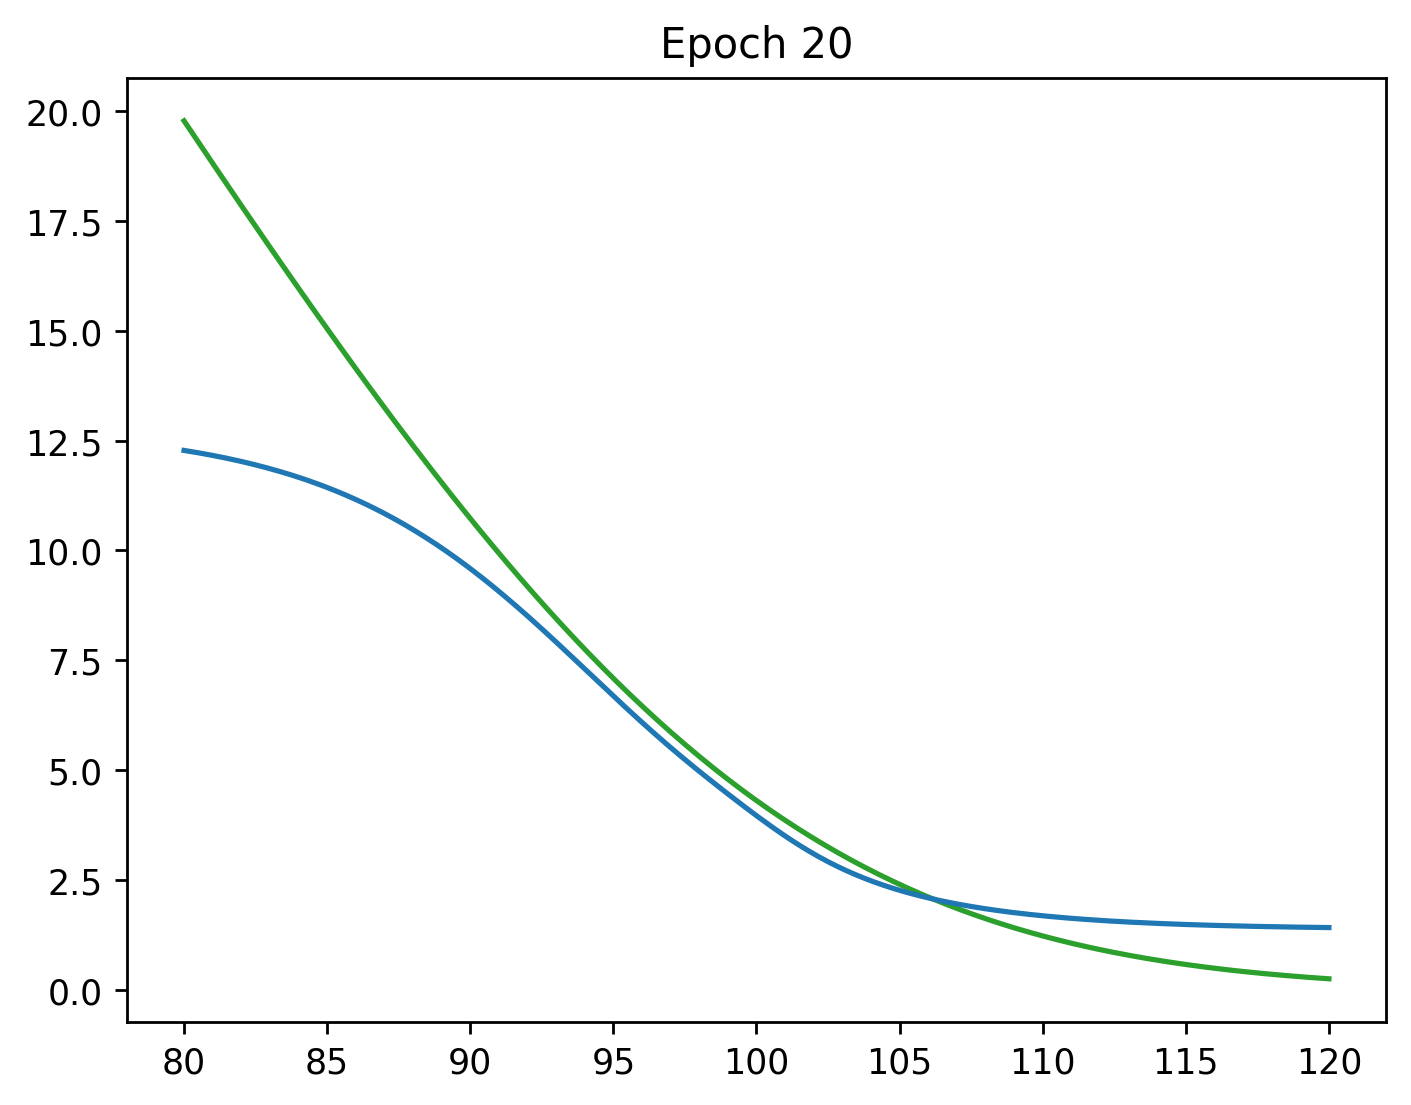

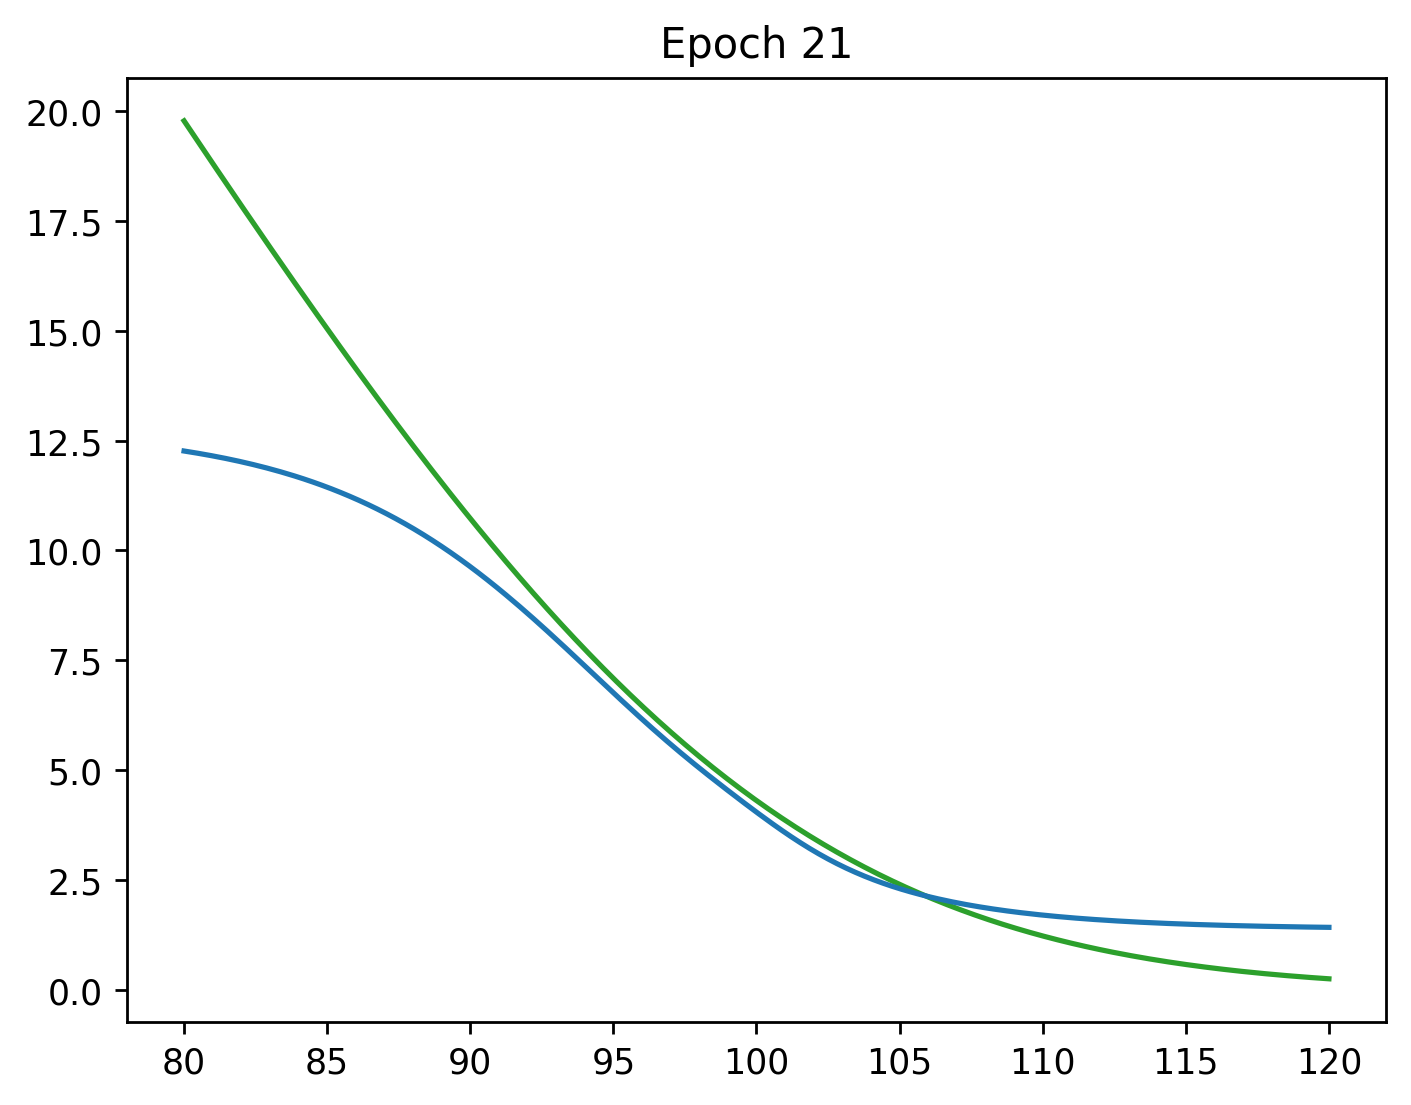

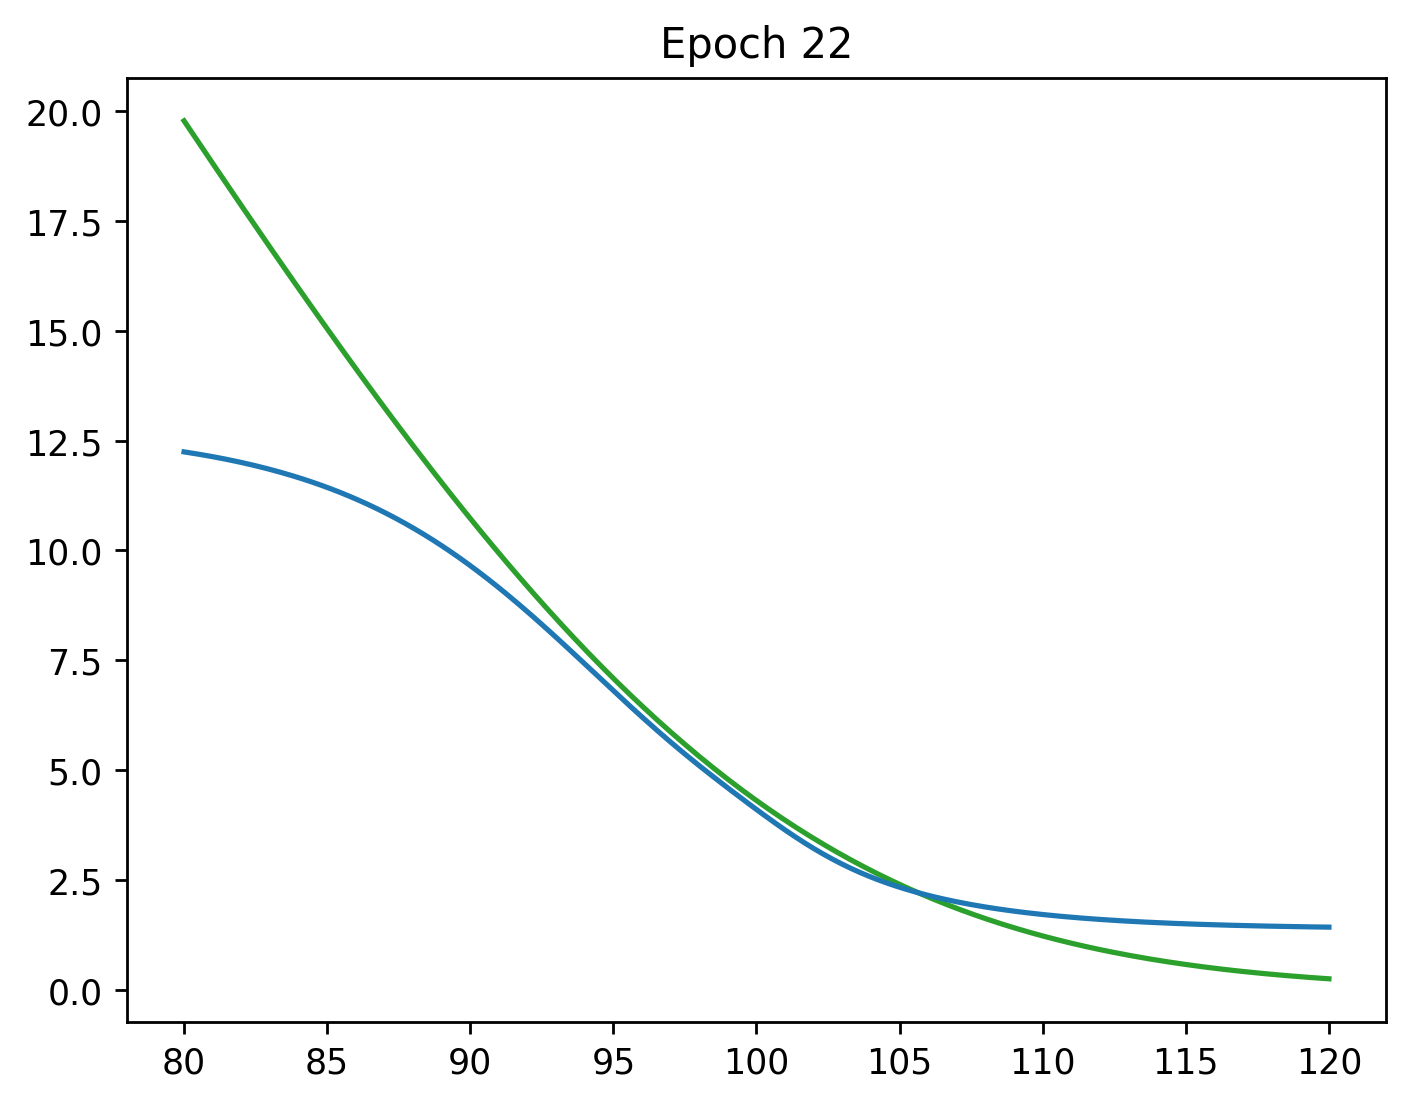

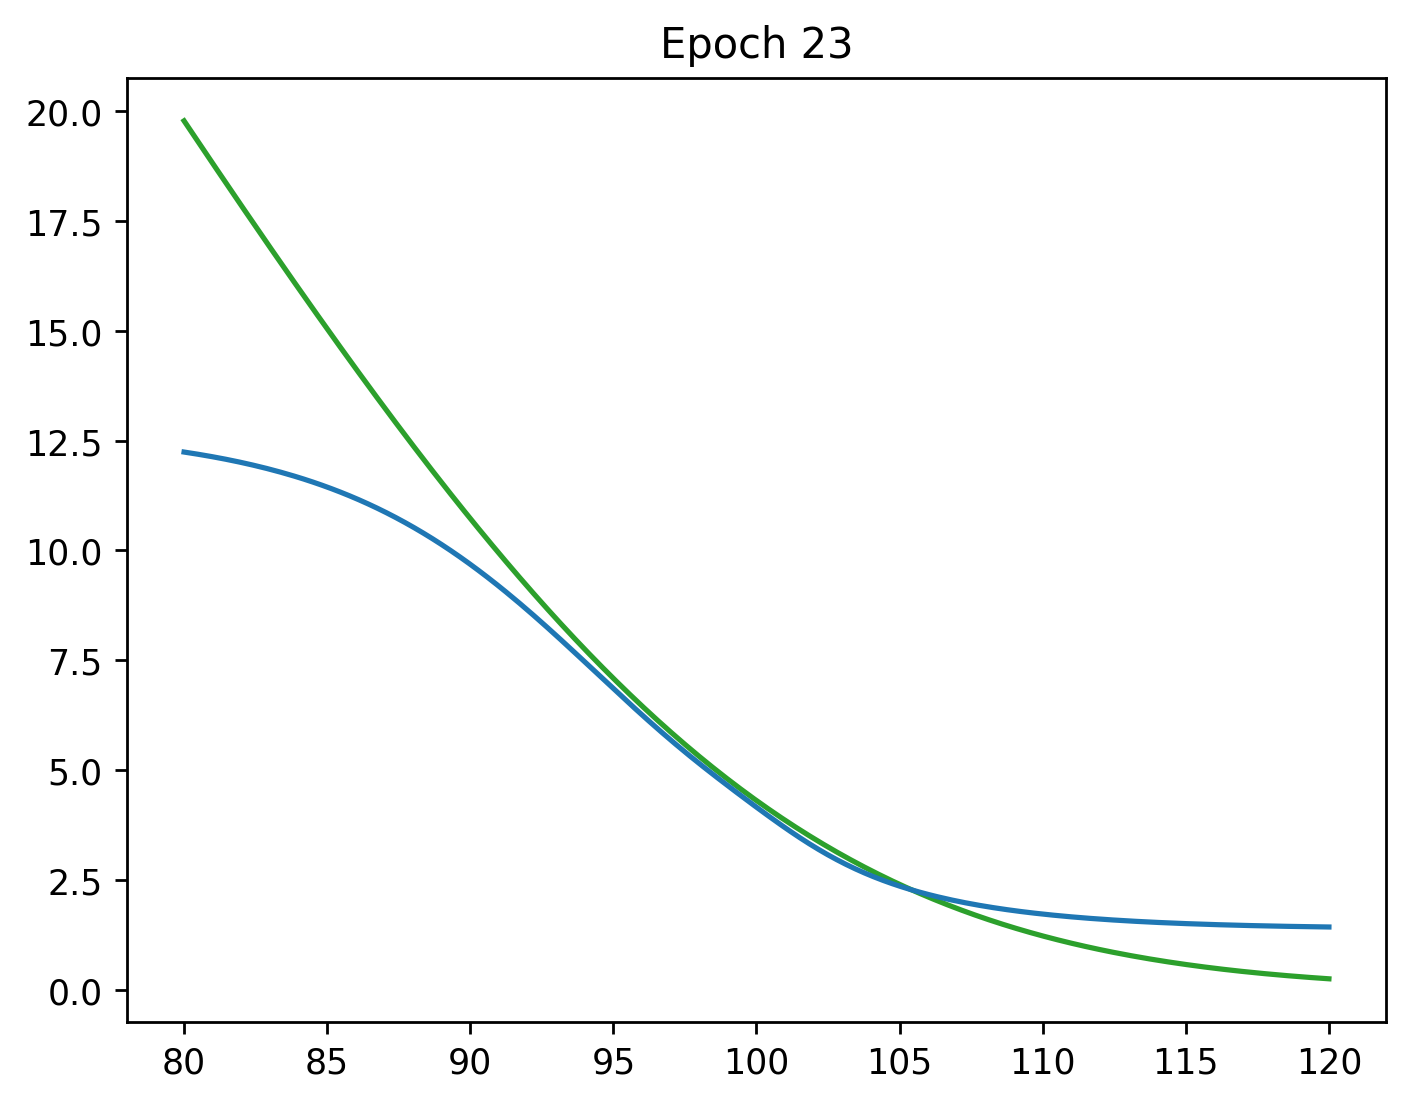

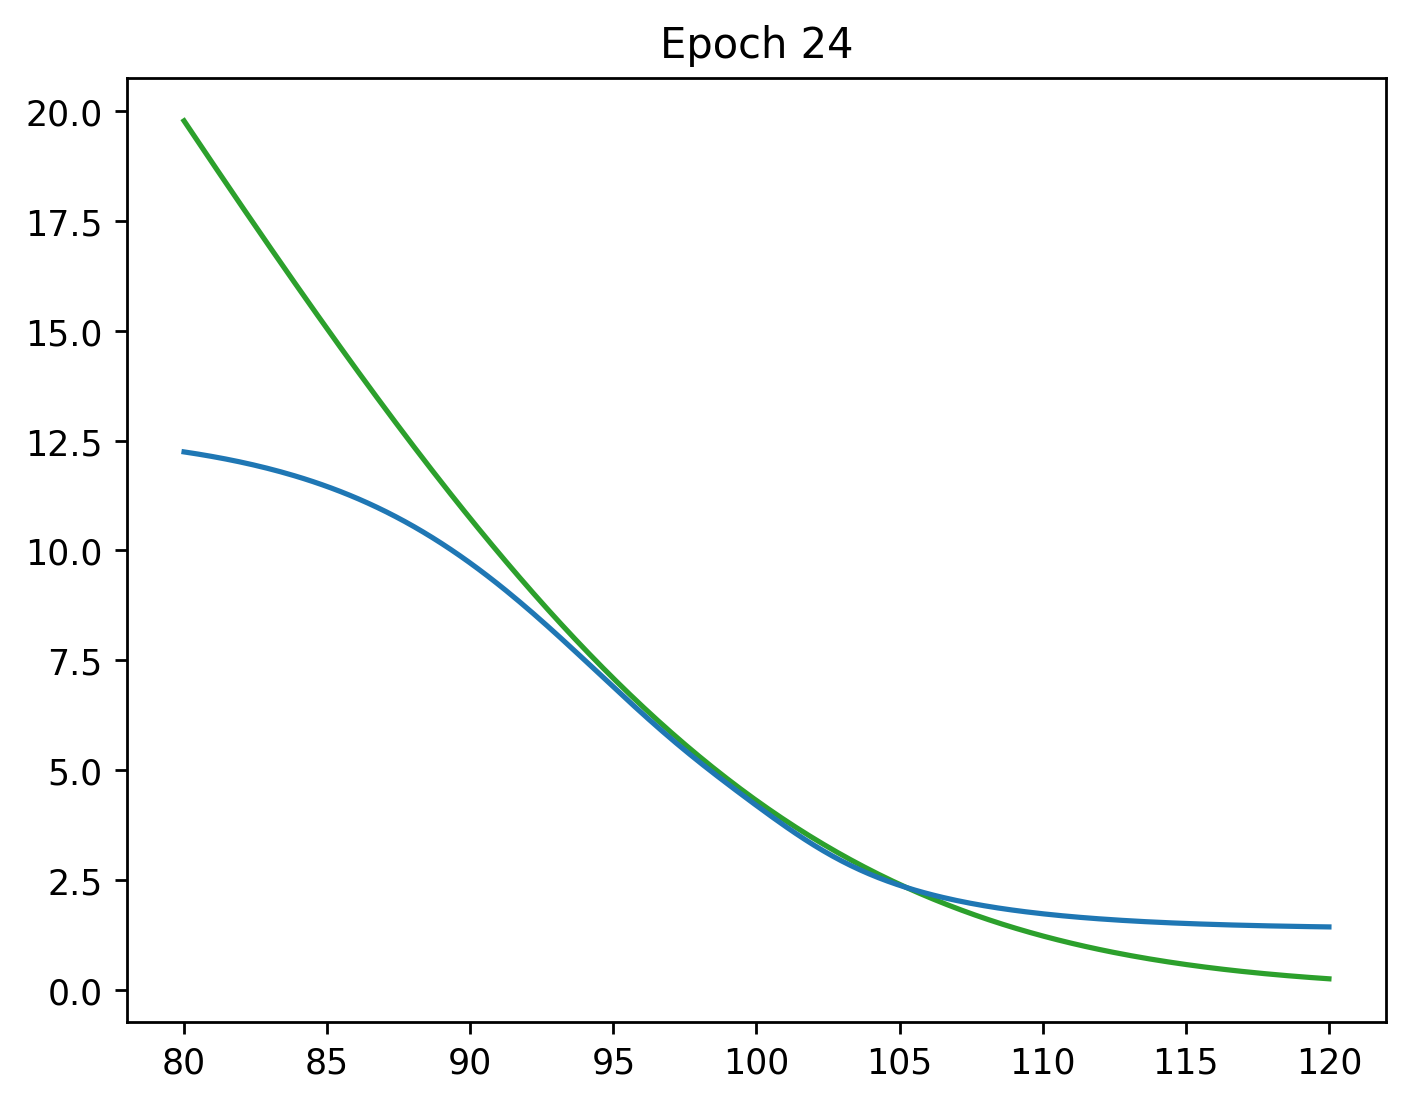

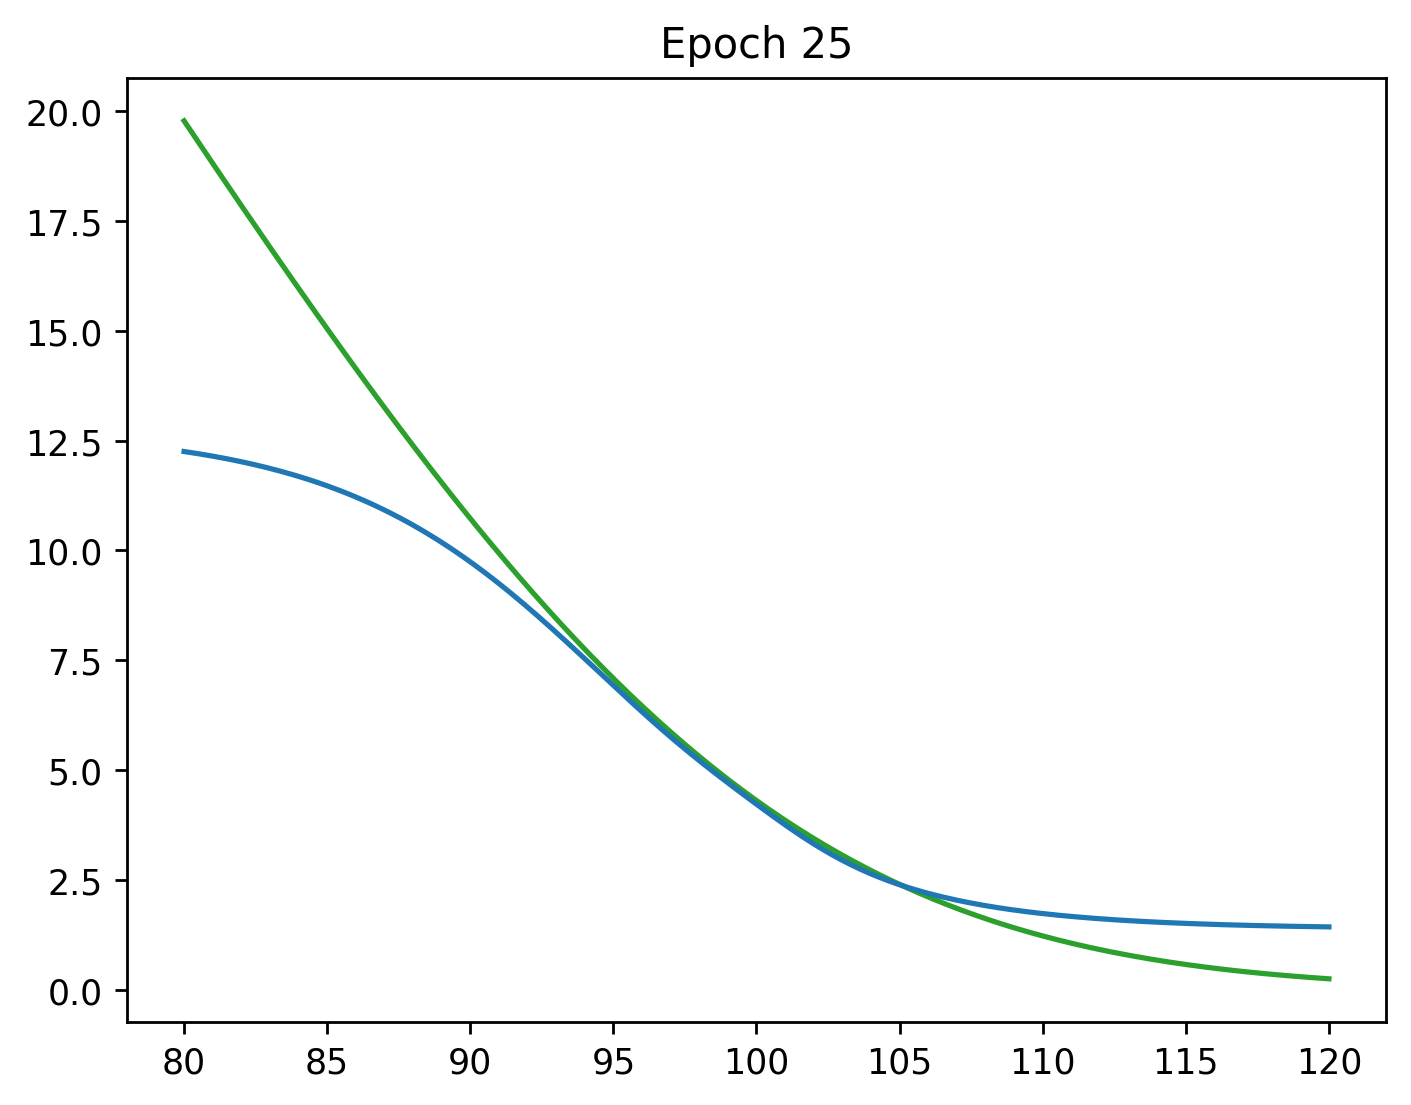

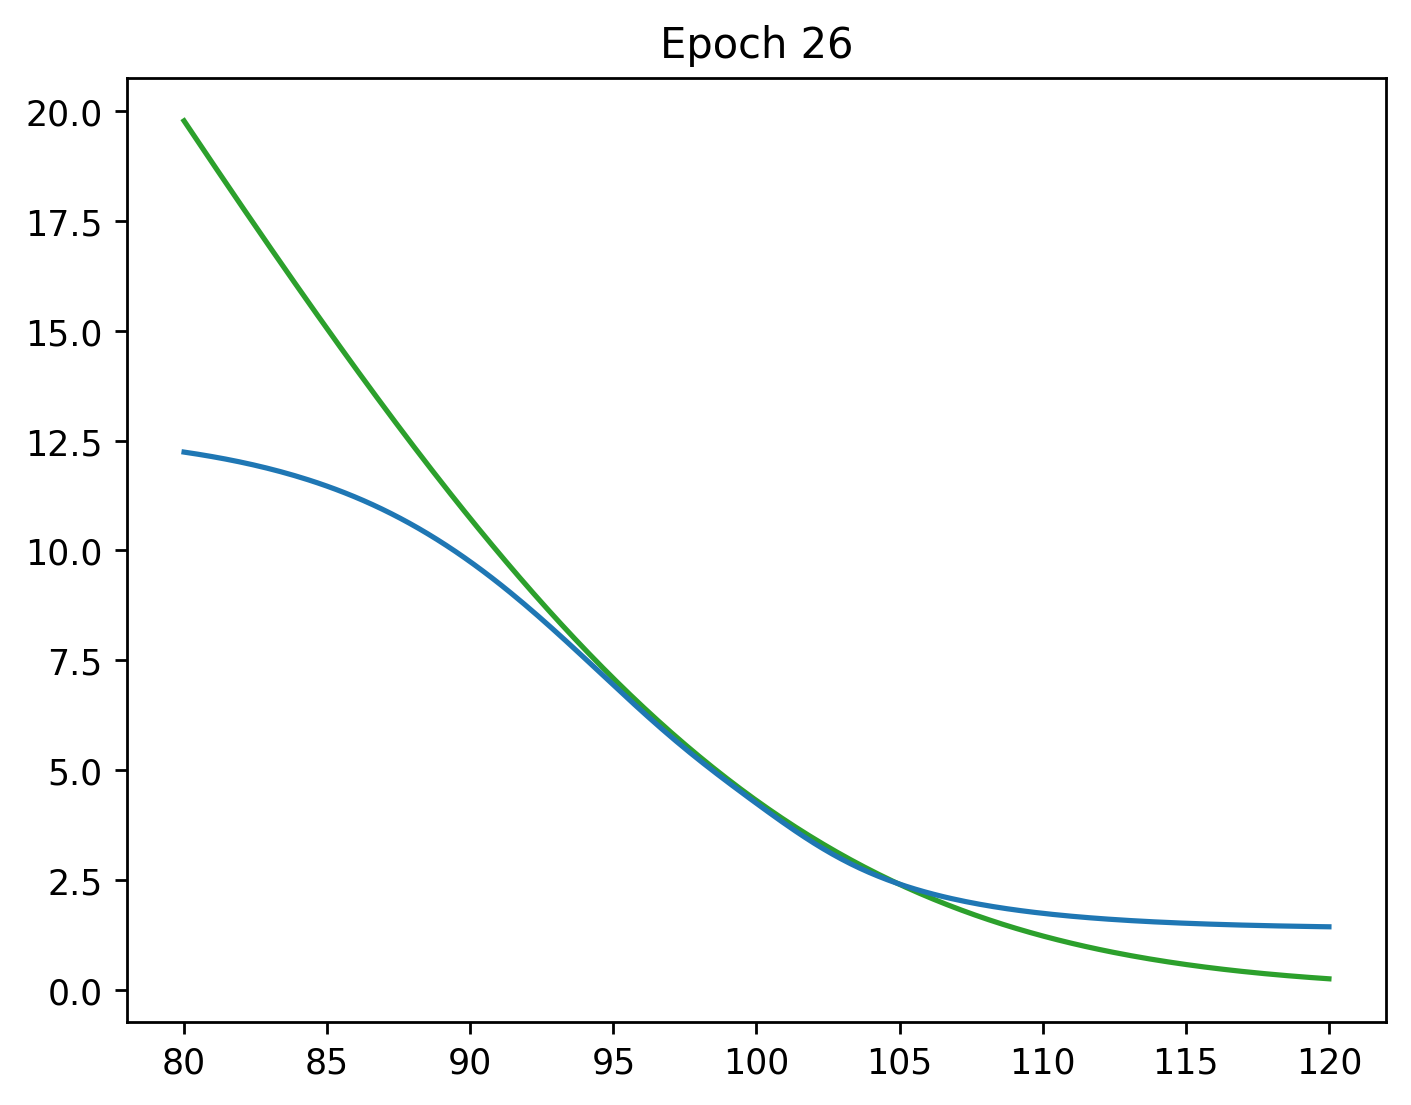

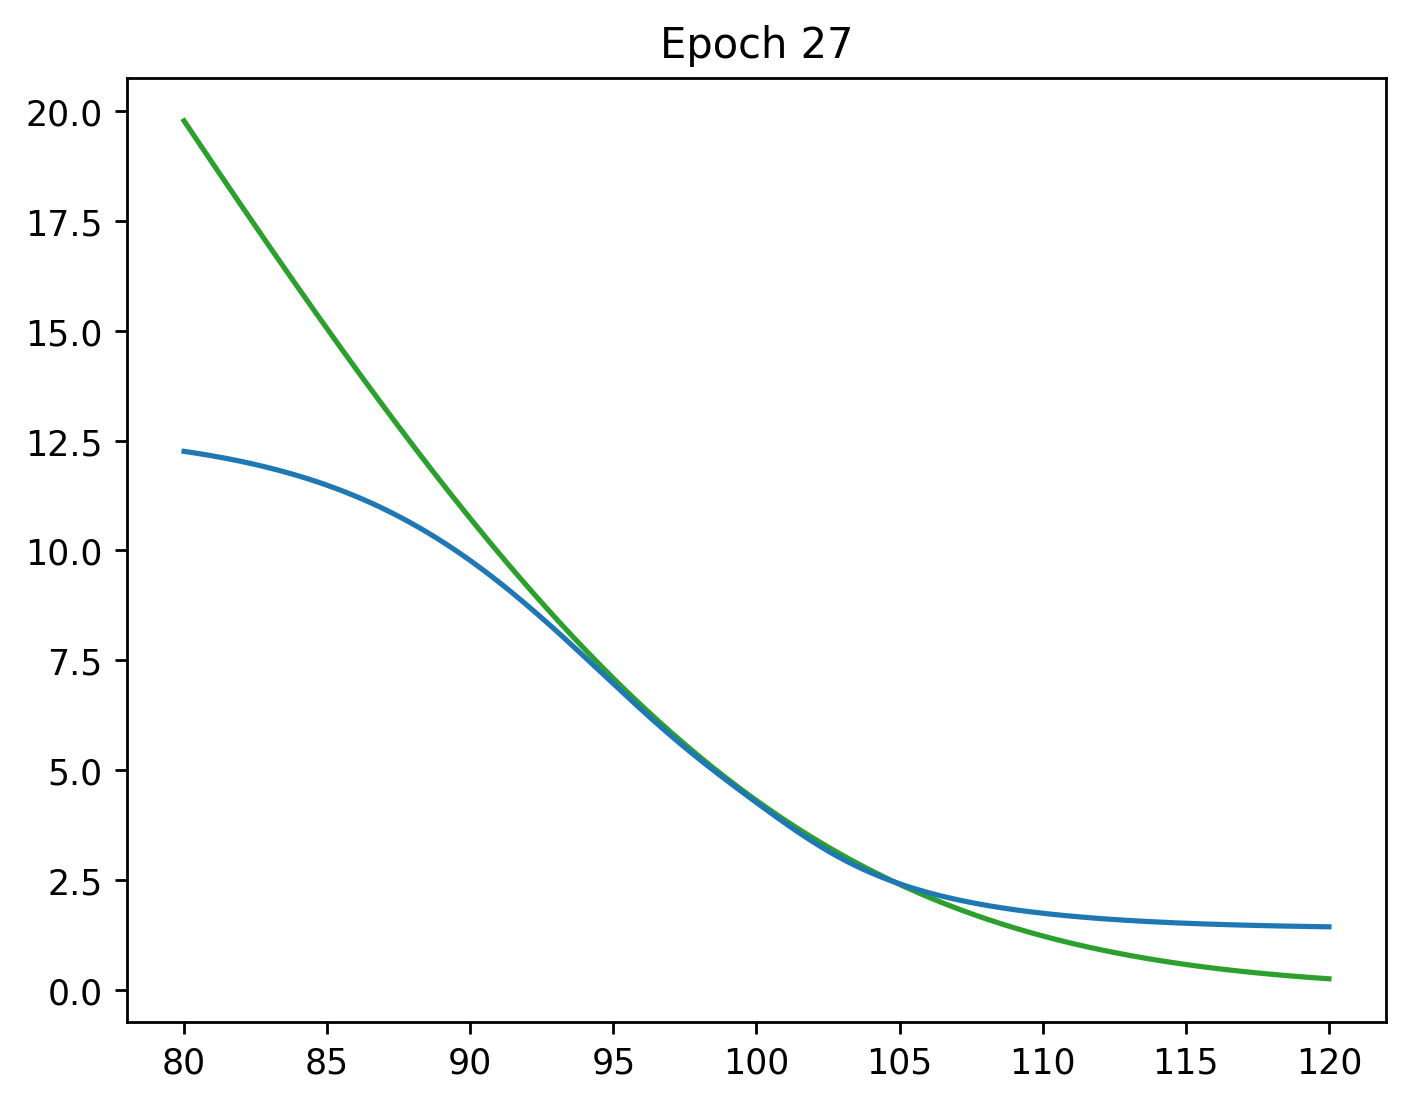

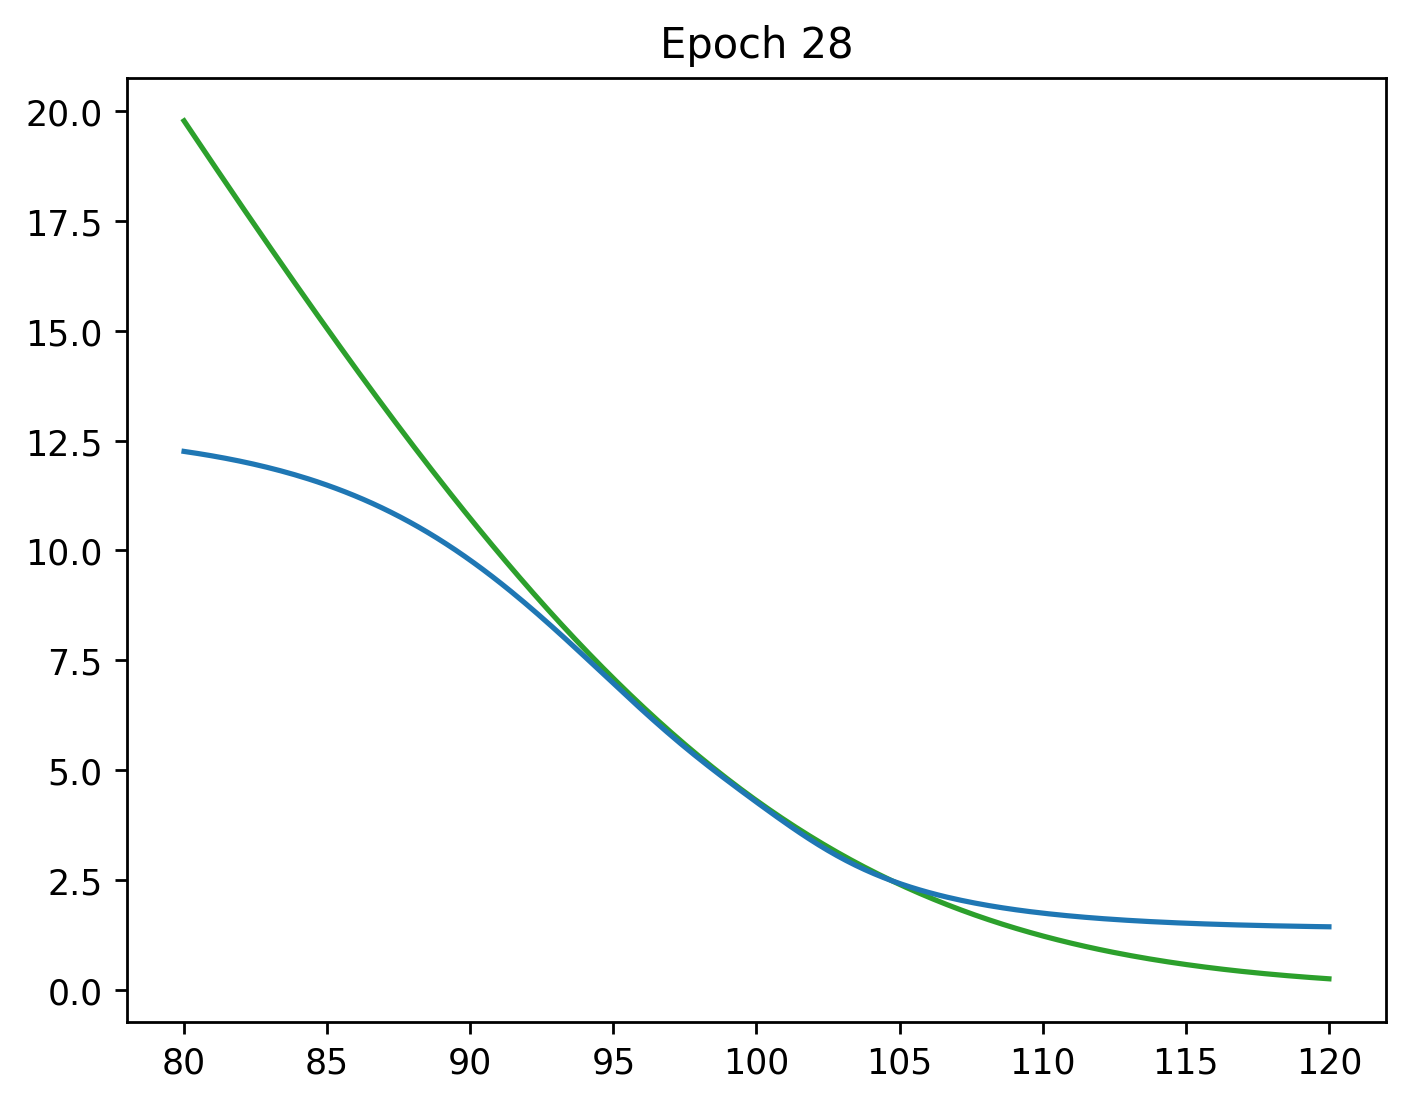

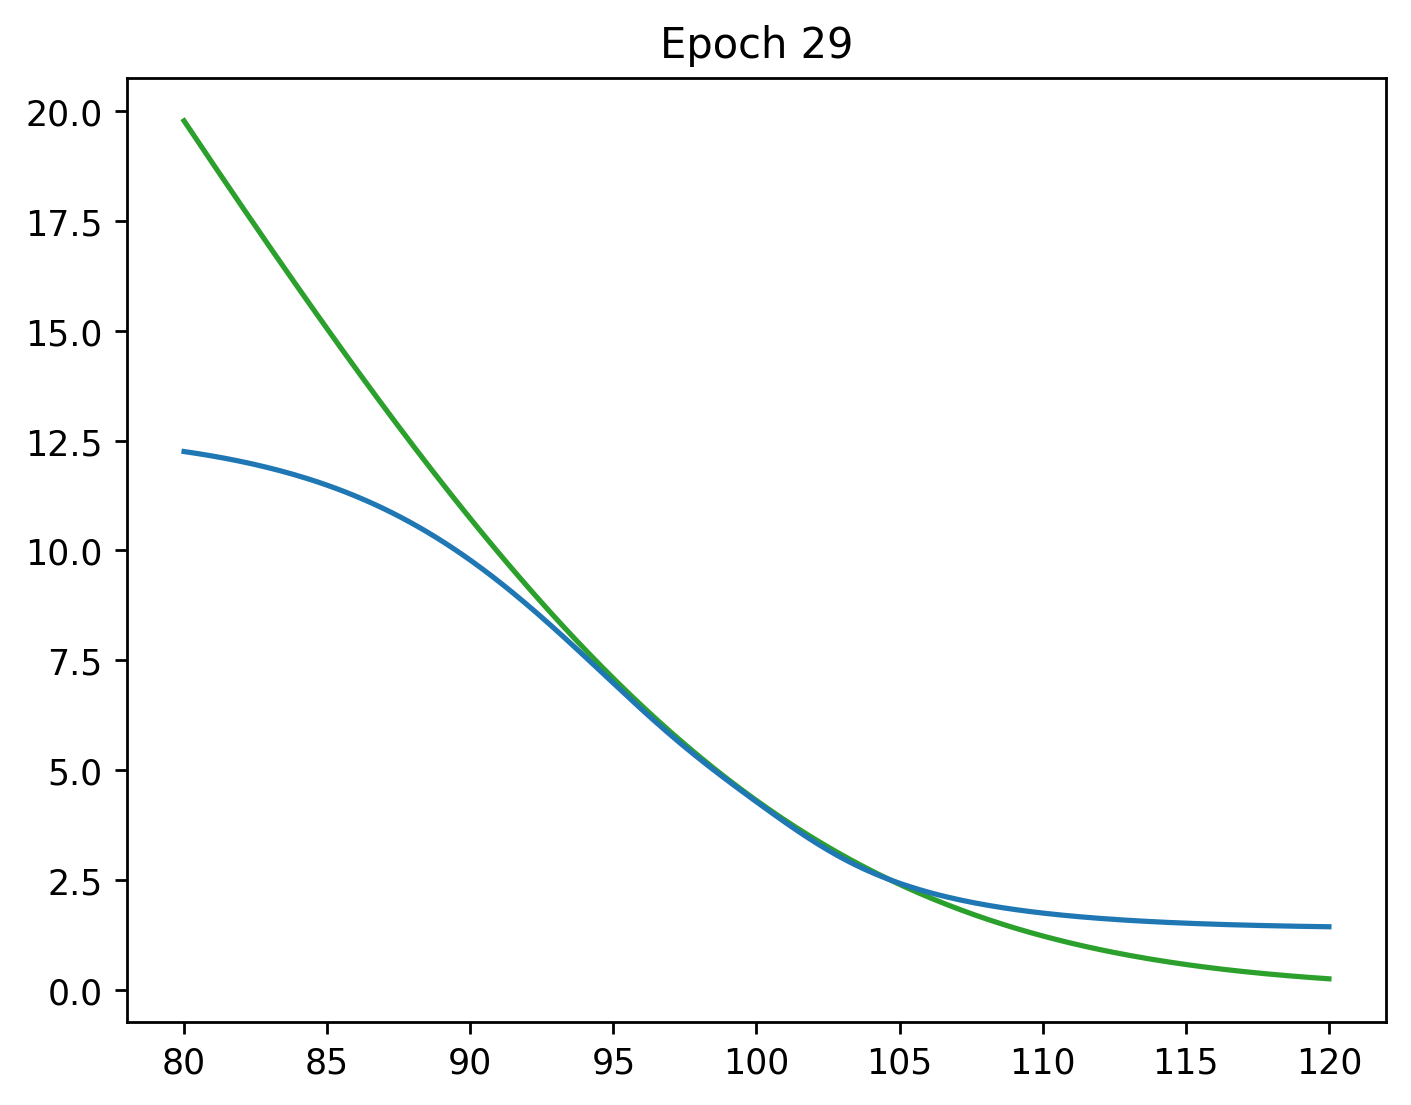

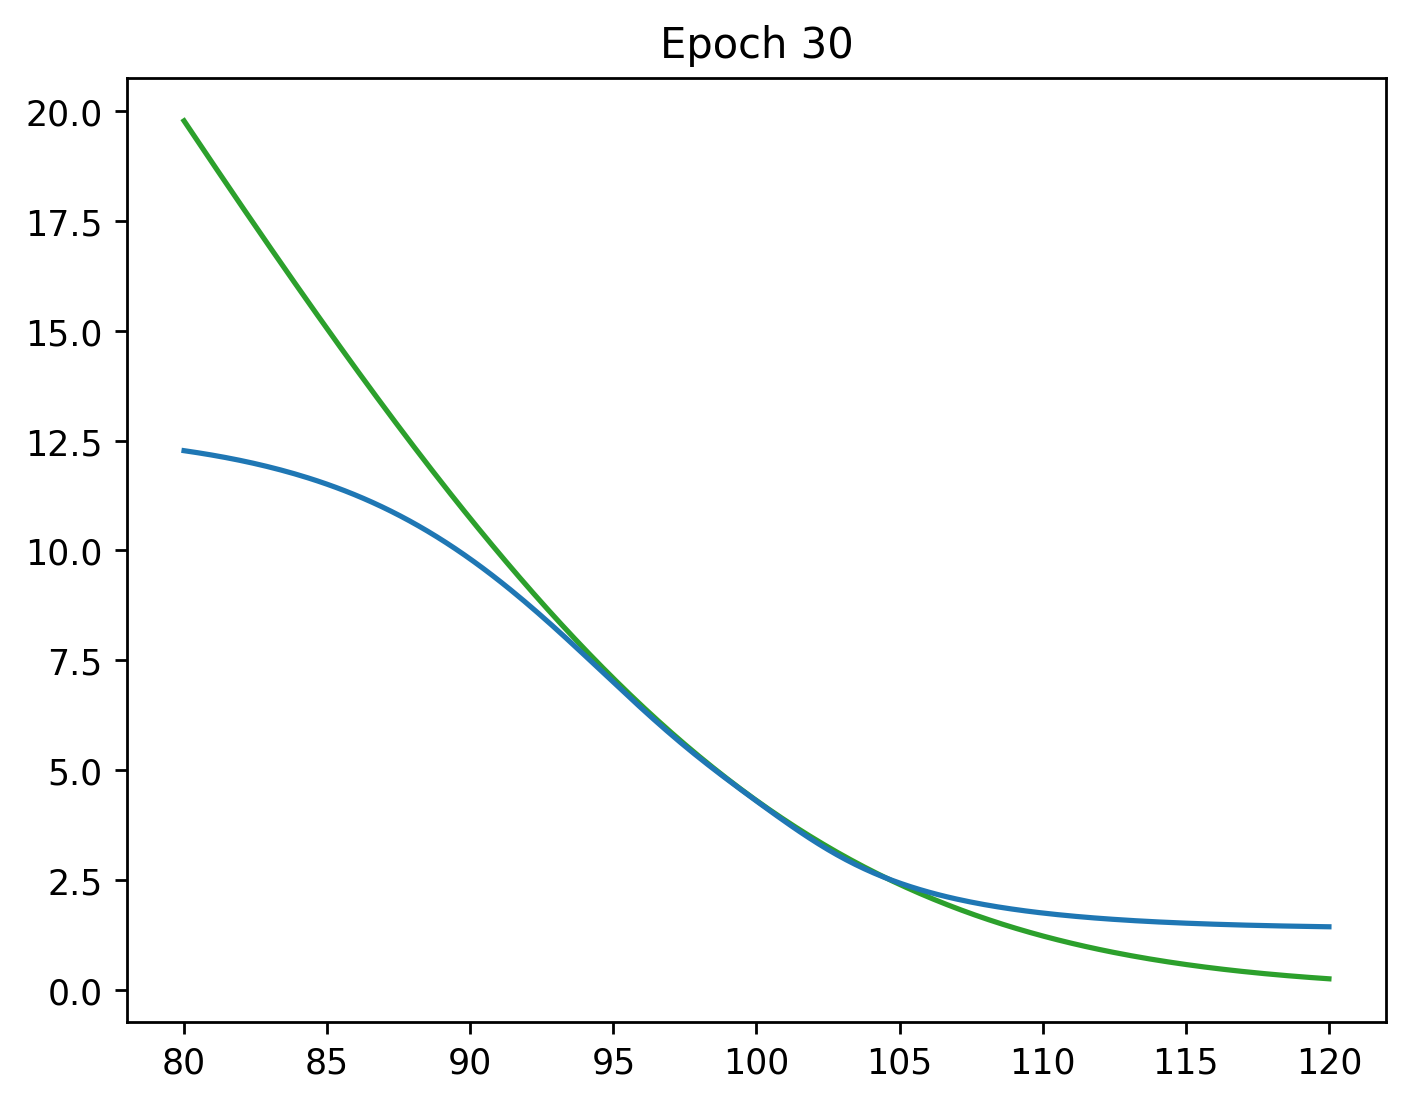

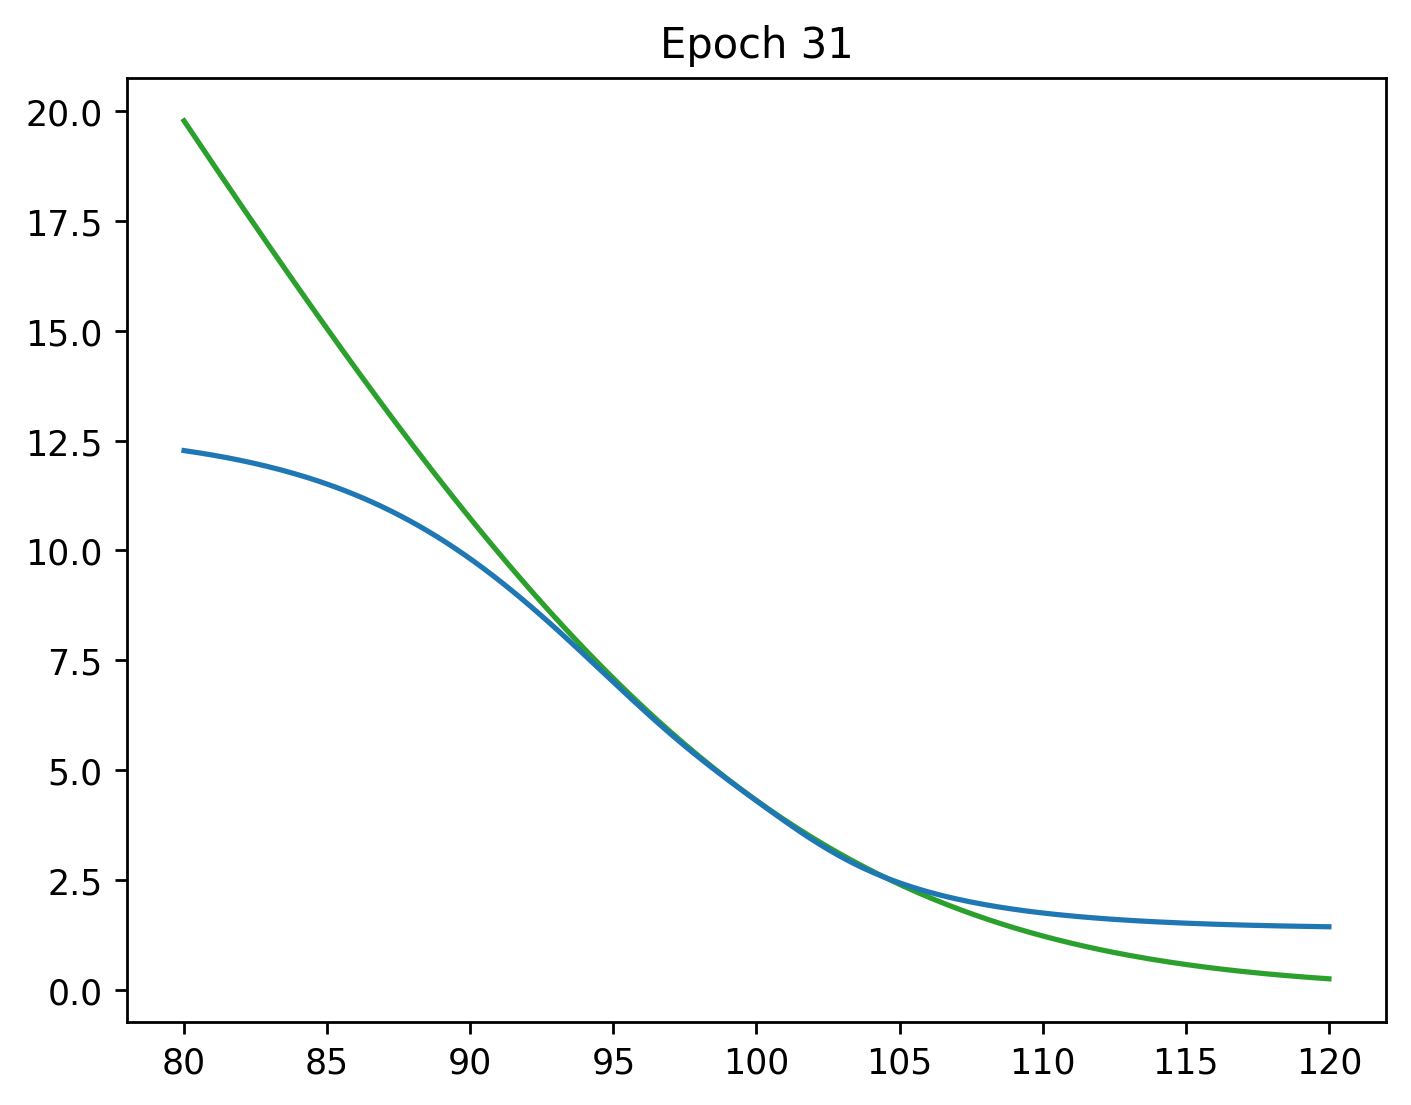

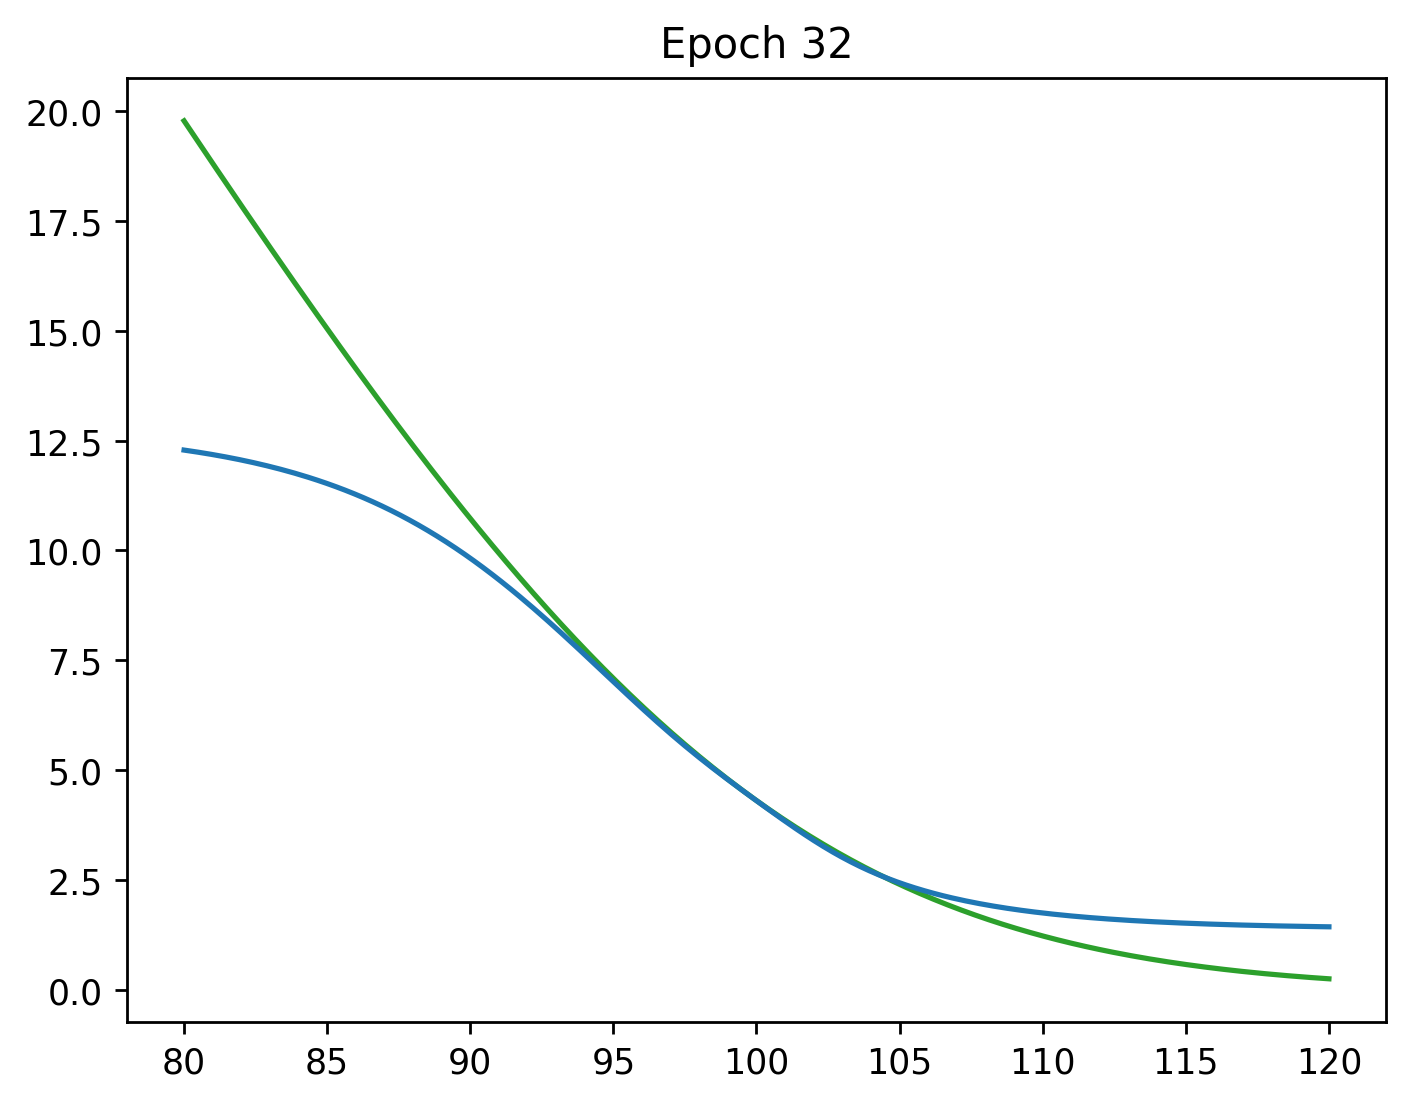

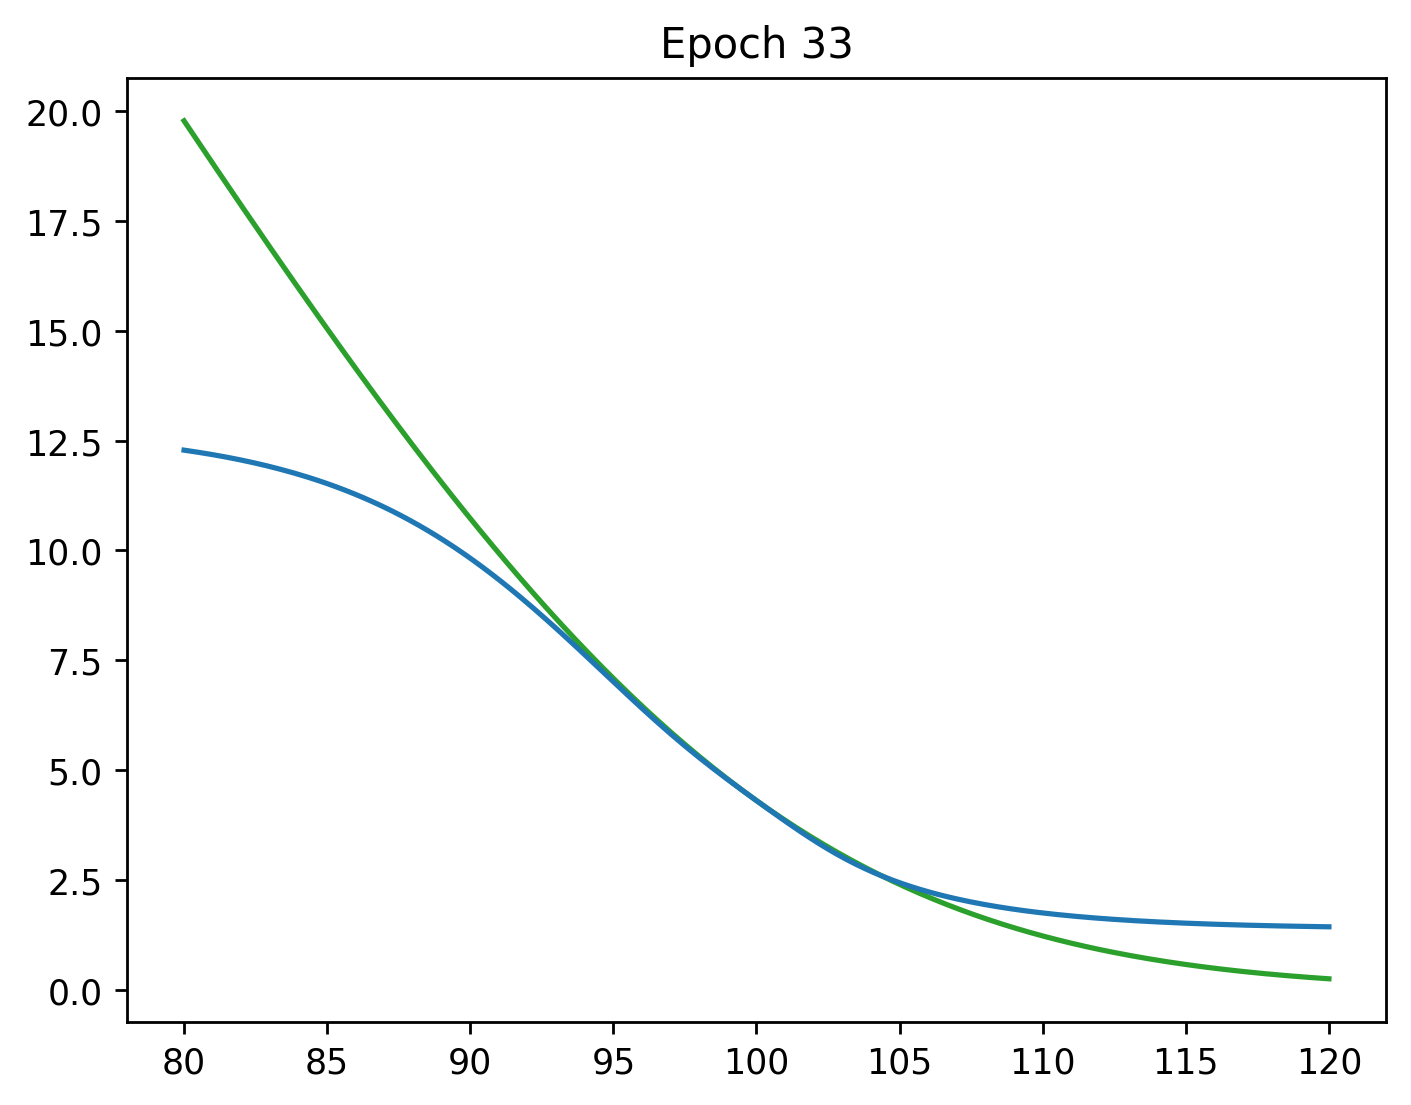

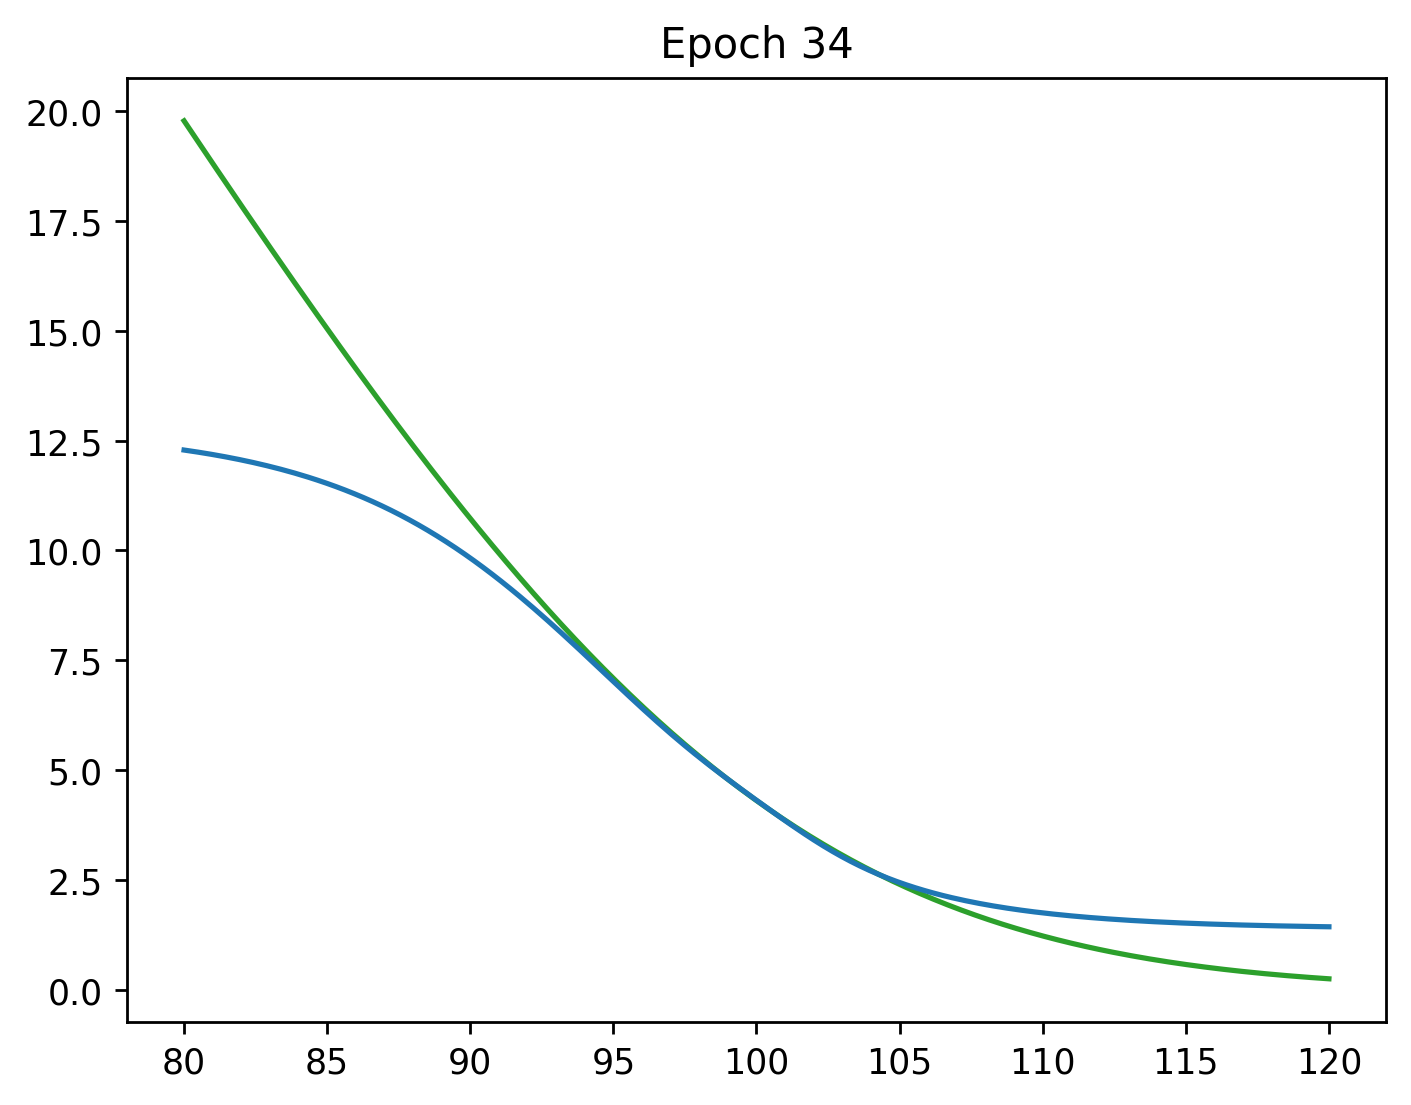

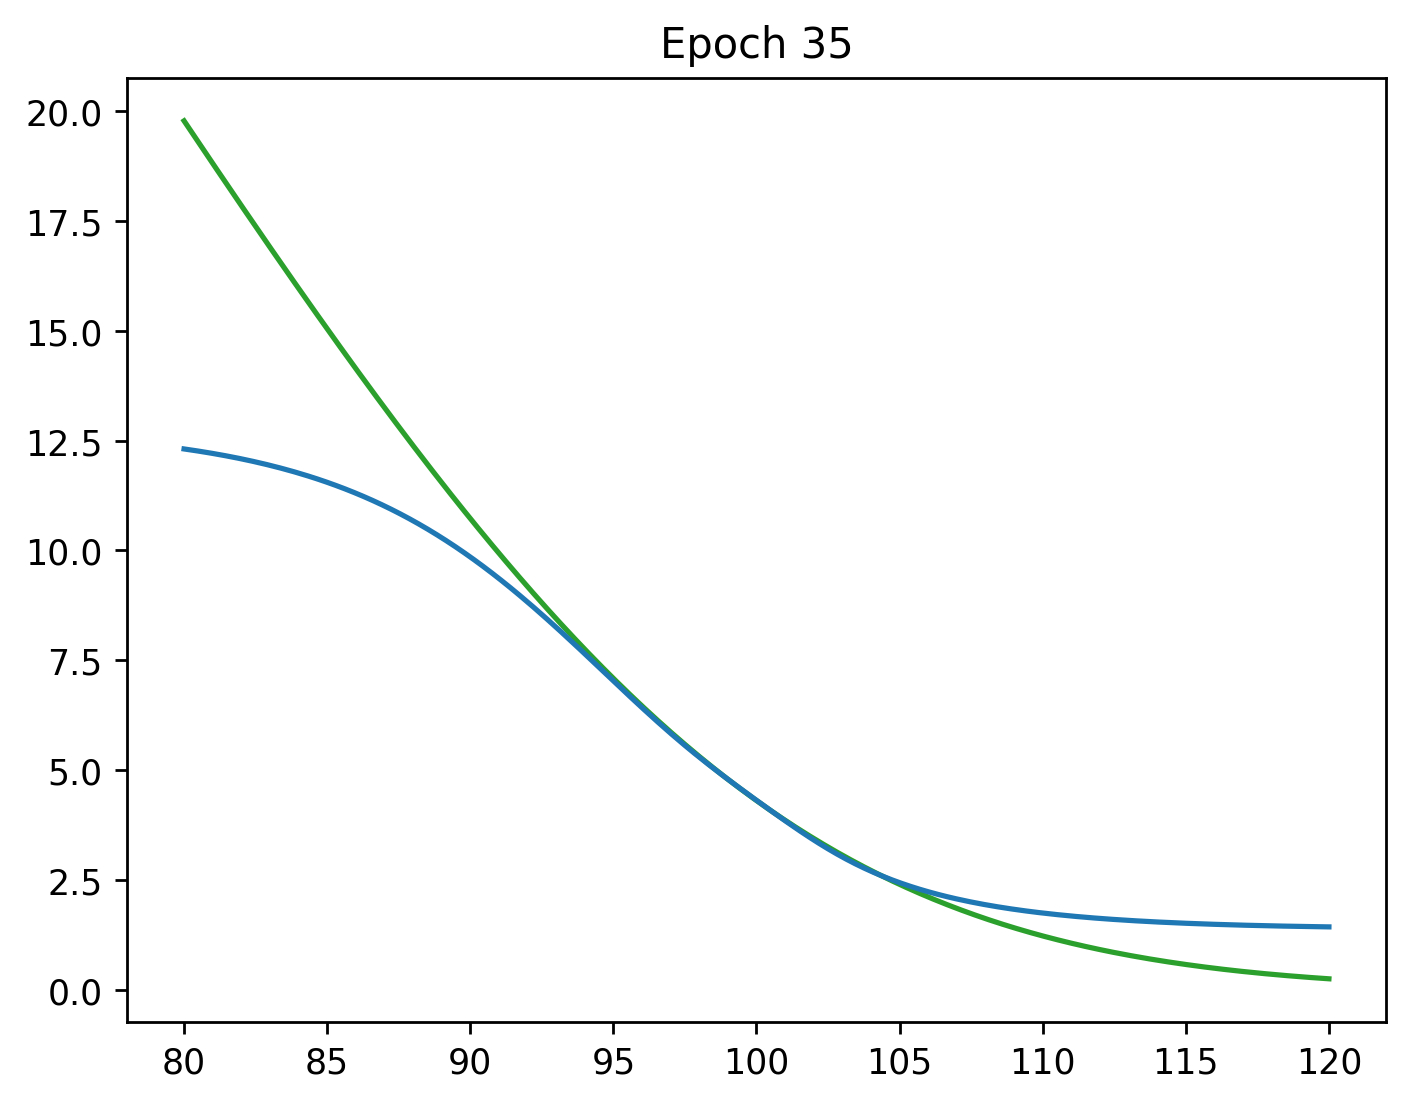

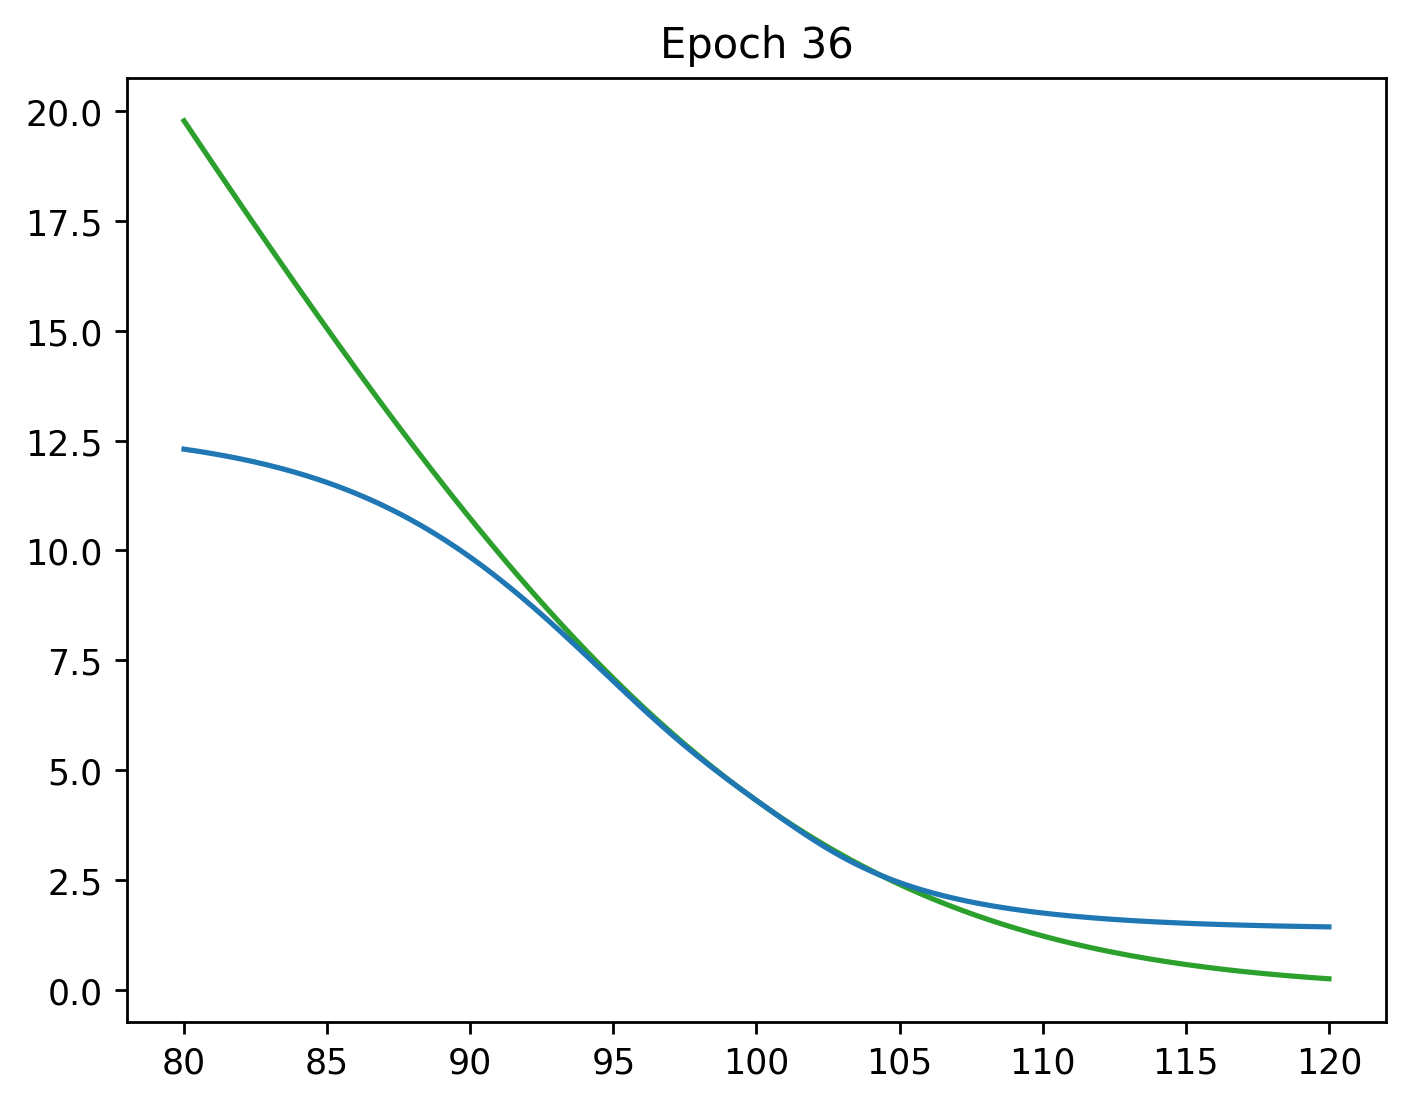

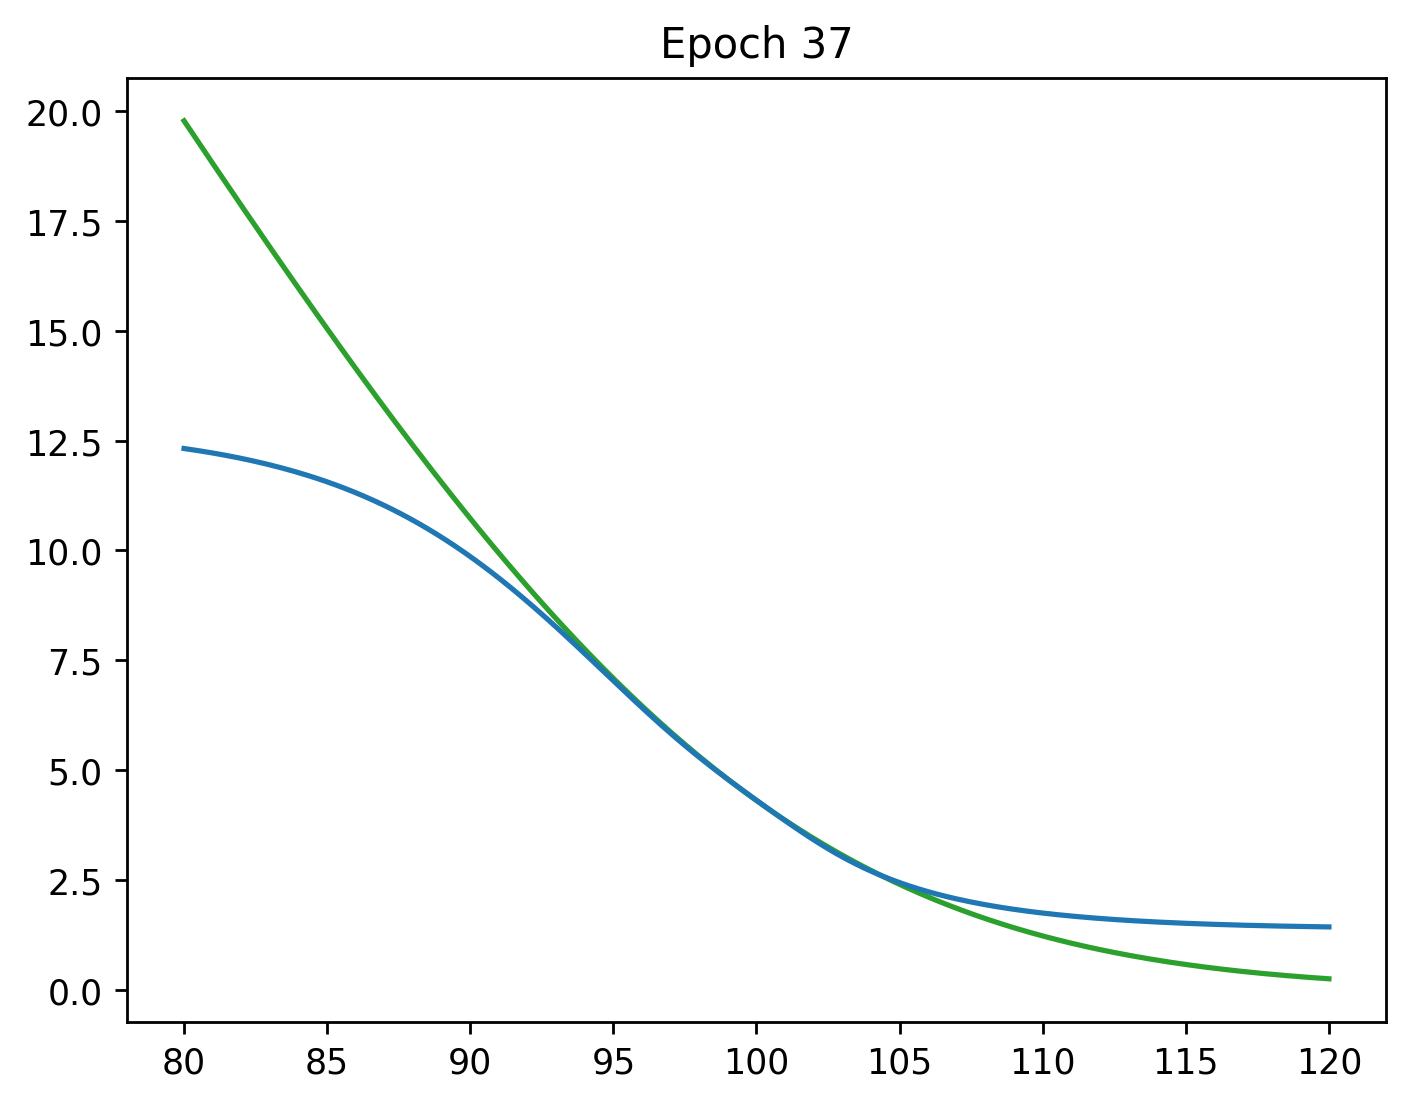

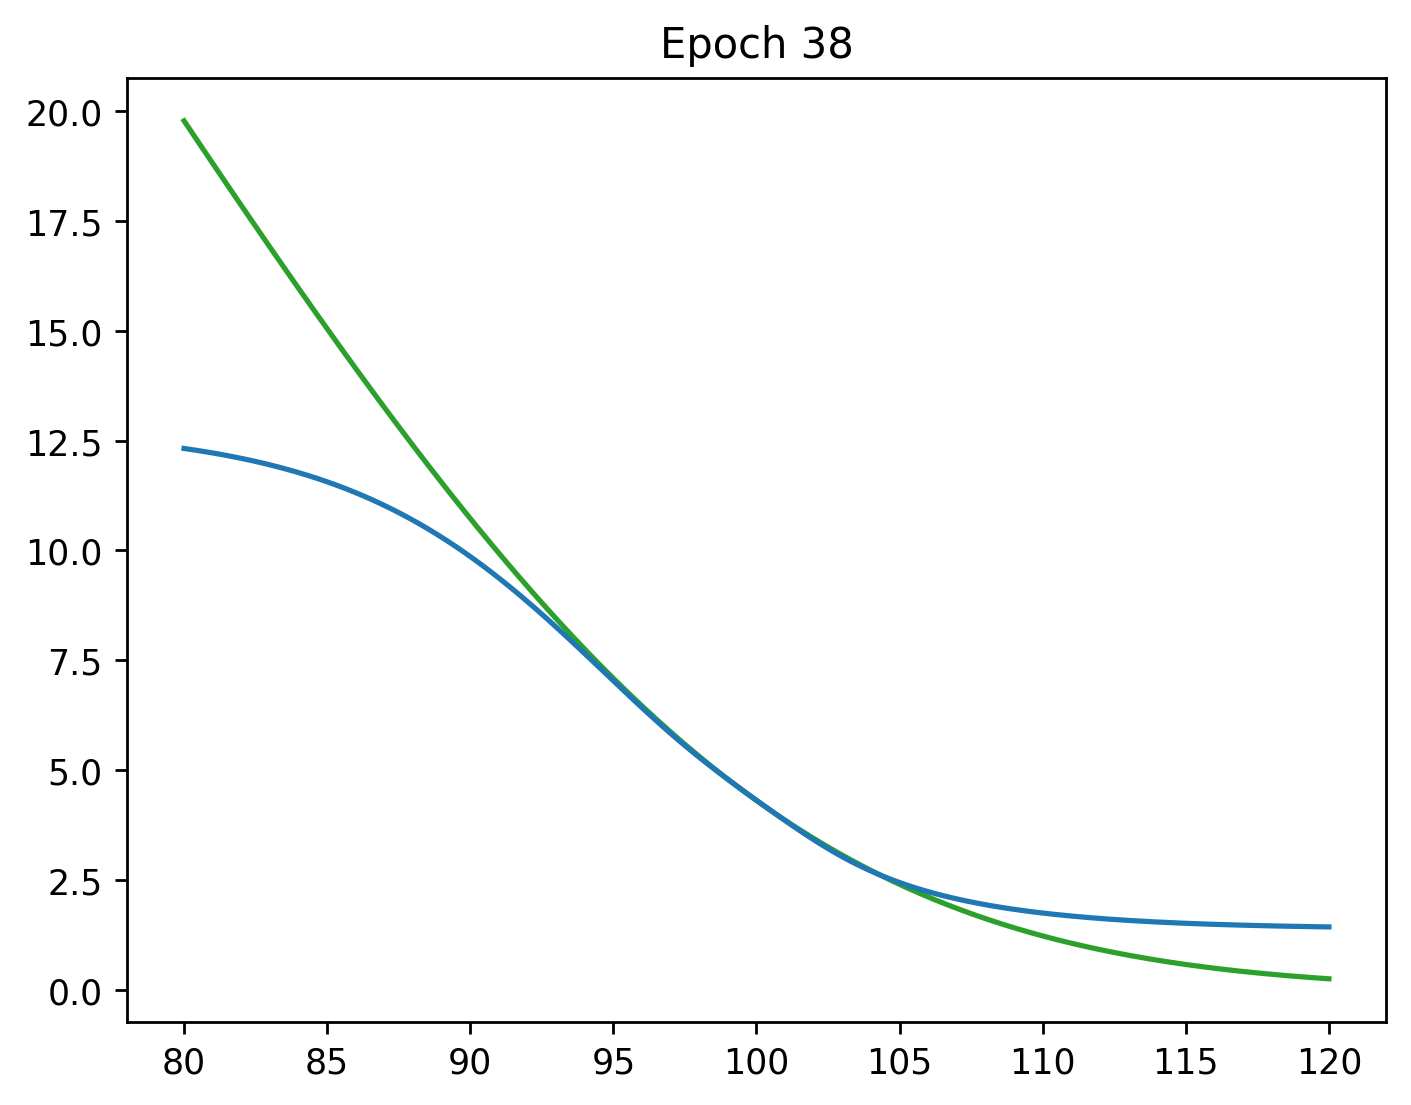

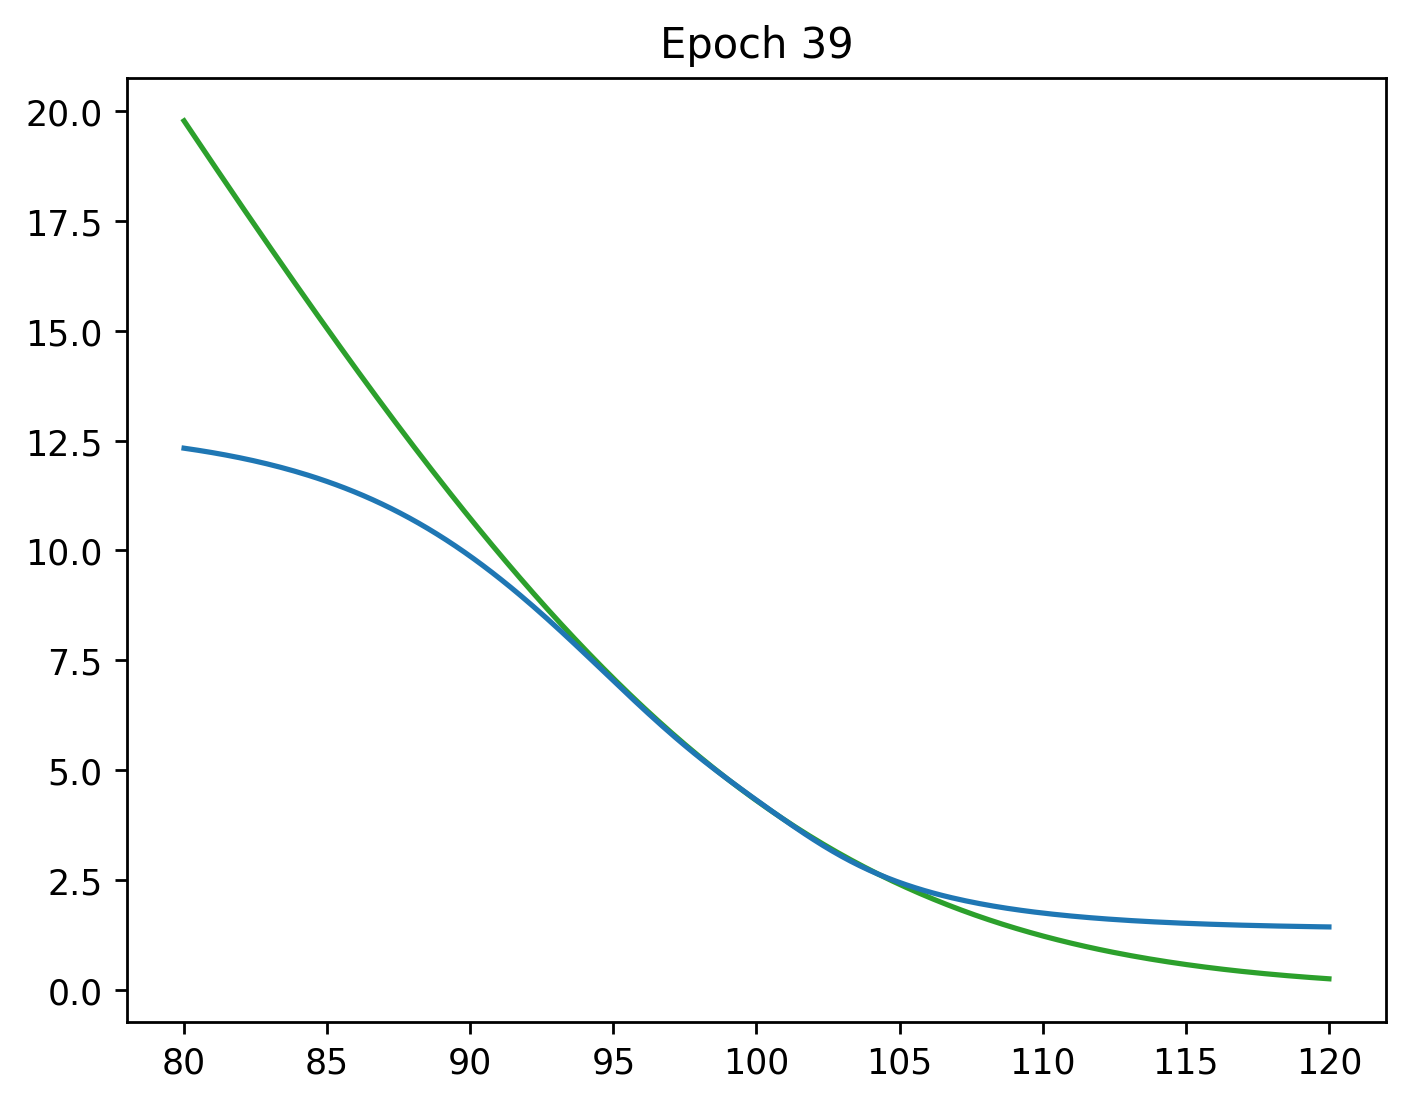

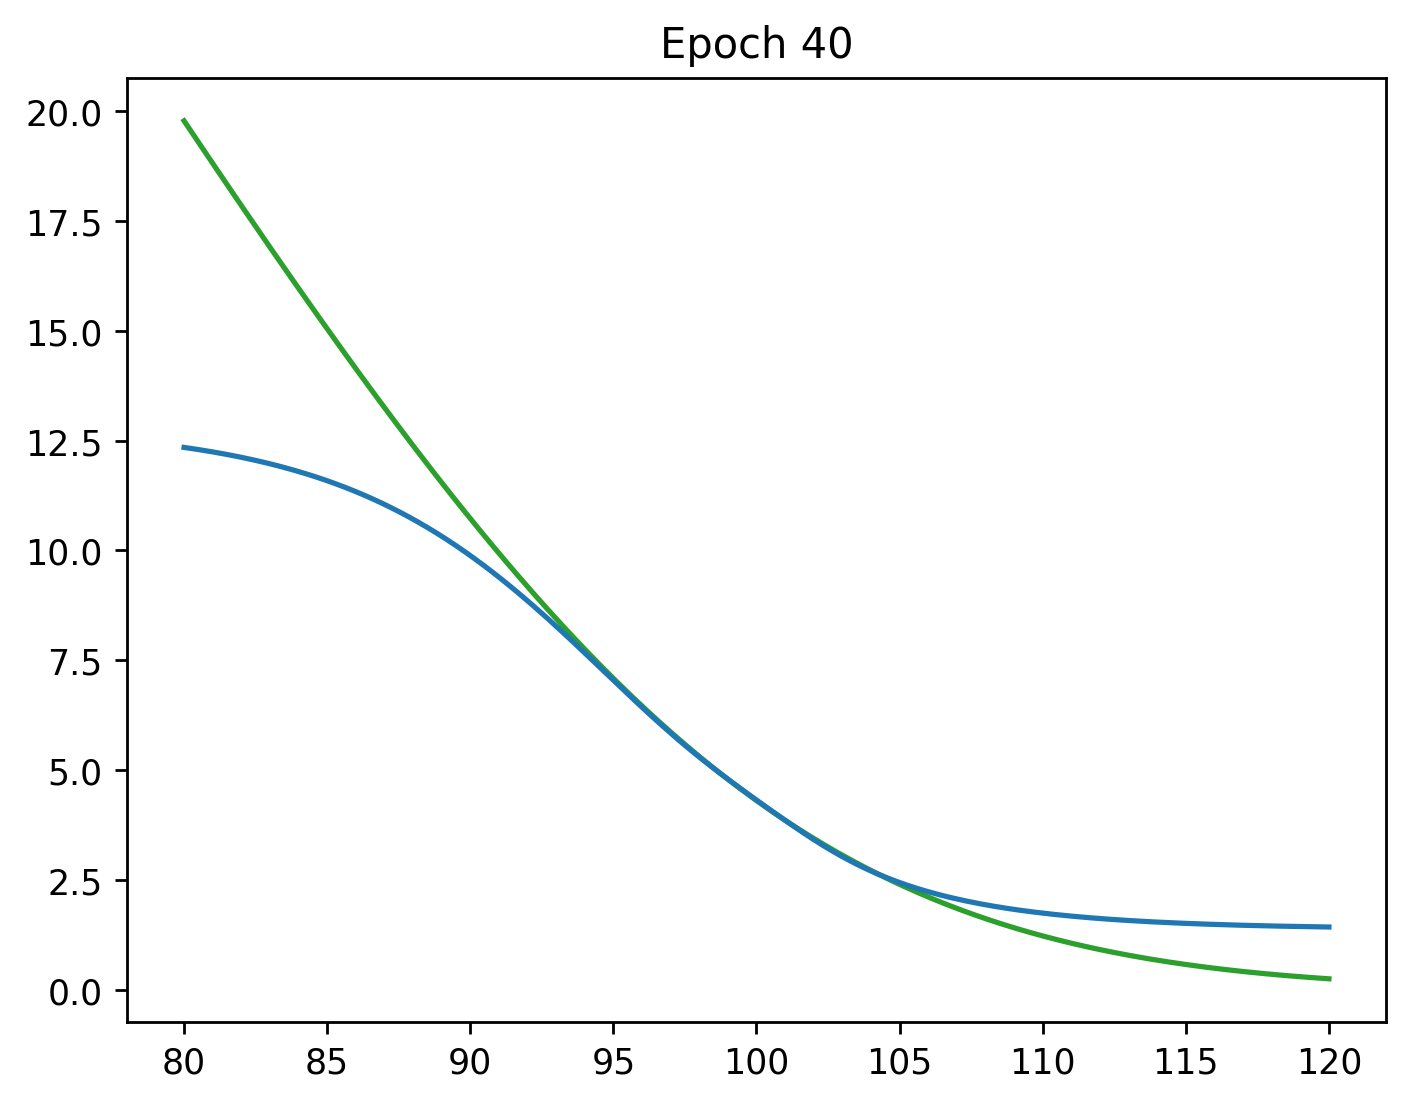

In [48]:
for i in range(40):
    plt.figure(figsize=(6.5,5),dpi=250)
    plt.plot(u,P_T_true(u), color='tab:green')
    plt.plot(u,models_eval[i].predict(u)[:,0], color='tab:blue')
    plt.title('Epoch '+str(i+1))
    plt.show()